# Imports

In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import importlib
import utils
import attention
import glob
from collections import defaultdict

import seaborn as sns
import pandas as pd
import os
import math

# Heat map for regression exps

In [ ]:
from scipy import interpolate
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm


def in_notebook():
    try:
        from IPython import get_ipython
        if 'IPKernelApp' not in get_ipython().config:  # pragma: no cover
            return False
    except ImportError:
        return False
    except AttributeError:
        return False
    return True

def show_plt_if_in_notebook(title=None):
    if in_notebook():
        plt.show()
    else:
        plt.savefig(title)
def get_record(  is_online, extra = "", title = None,  
               zero_out_list = None,
               image_transform_loader_list = None,
               tiling_orientation_ablation_list = None,
               tiling_list = None,
               outdir = "/scratch/gpfs/qanguyen/poly1/",
              palette = sns.color_palette("Set3", 10),
               hue_variable = "data_rescale",
               num_hidden_features_list = None,
               max_epoch = 0
):
     
    warnings.filterwarnings(action='once')
    train_pars = defaultdict(list)
    val_pars = defaultdict(list)
    #record_names = ['resnet18_rep_1673625625.387933.pkl', 'resnet18_rep_1673618285.140812.pkl', 
    #               'resnet18_rep_1673618285.124871.pkl', 'resnet18_rep_1673618315.142802.pkl',
    #               'resnet18_rep_1673618403.386129.pkl', 'resnet18_rep_1673618403.386123.pkl',
    #               'resnet18_rep_1673618381.887423.pkl', 'resnet18_rep_1673618474.561327.pkl',
    #               'resnet18_rep_1673625654.48548.pkl', 'resnet18_rep_1673614260.528039.pkl']
    
#     record_names = ['resnet18_rep_1673873160.304721.pkl', 'resnet18_rep_1673873238.133468.pkl',
#                   'resnet18_rep_1673873238.273423.pkl', 'resnet18_rep_1673873237.417957.pkl',
#                   'resnet18_rep_1673873267.69003.pkl', 'resnet18_rep_1673873267.029088.pkl',
#                   'resnet18_rep_1673873267.064156.pkl', 'resnet18_rep_1673873329.711897.pkl',
#                   'resnet18_rep_1673873329.711921.pkl', 'resnet18_rep_1673873376.545421.pkl']
    record_names = ['resnet18_rep_1674056611.865267.pkl', 'resnet18_rep_1674056612.392694.pkl',
                  'resnet18_rep_1674056625.227239.pkl', 'resnet18_rep_1674057094.9487.pkl',
                  'resnet18_rep_1674058958.82337.pkl', 'resnet18_rep_1674059096.368824.pkl',
                  'resnet18_rep_1674059129.166538.pkl']#, 
#                     'resnet18_rep_1673873329.711897.pkl',
#                   'resnet18_rep_1673873329.711921.pkl', 'resnet18_rep_1673873376.545421.pkl']
    
    record_names = glob.glob(f"{outdir}/random_noisyJUN15*pth.tar")
    #record_included = [int(r.split("_")[-1].split(".")[0]) for r in record_names]
    #record_included = [((r > 1675853450) and (r < 1675912720)) for r in record_included]
    #record_names = [ r for i,r in enumerate(record_names) if record_included[i] == True]
    #print(record_names, len(record_names))
    for _, f in enumerate(record_names) :
        #print(f)
        try:
            
            record = torch.load(f, map_location="cpu") 
        except Exception as e: 
            print(e)
        
        try:
            #if record.curr_epoch > 27:
            #    continue
            #print(w)
              
            #print( record.args )

            #if (zero_out_list is not None) and (record.args.zero_out not in zero_out_list):
            #    continue
            
            if (num_hidden_features_list is not None) and (record.args.num_hidden_features not in num_hidden_features_list):   
                continue
        except Exception as e: 
            print(e)
            print(f, "continue", record.curr_epoch )
            continue
        
        #print(f, "plotting" )
        for epoch in [max_epoch]:
        #for epoch in range( 1):
            #print(epoch, f)
            
            #pars["data_rescale"].append(record.data_rescale)
            #pars["data_rescale"].append(record.args.growth_factor)
            #pars["tiling_imagenet"].append(record.args.tiling_imagenet)
            val_pars["block_size"].append(f'{record.args.coarsegrain_blocksize}')
            train_pars["block_size"].extend( [record.args.coarsegrain_blocksize]) 
            #val_pars["lr"].append(f'{record.args.lr}')
            #train_pars["lr"].extend([ record.args.lr]  * len(record.metrics.train_losses[epoch]))
            val_pars["P"].append(record.args.num_hidden_features)
            train_pars["P"].extend([ record.args.num_hidden_features ])
            width_after_pool = math.floor((224 - record.args.coarsegrain_blocksize) / record.args.coarsegrain_blocksize + 1)
            D = 3*(width_after_pool)*(width_after_pool)
            val_pars["D"].append( D)
            train_pars["D"].extend([D]) 
            N =  record.args.num_train_samples
            val_pars["N"].append(N)
            train_pars["N"].extend([N])
            val_pars["logP/D"].append( np.log( record.args.num_hidden_features / D ))
            train_pars["logP/D"].extend([np.log( record.args.num_hidden_features / D) ])
            val_pars["logN/D"].append( np.log( N / D ))
            train_pars["logN/D"].extend([np.log( N / D) ])
            #val_pars["P"].append(f'{record.args.num_hidden_features}')
            #train_pars["P"].extend([ record.args.num_hidden_features ])
            val_pars["epoch"].append(epoch)
            train_pars["epoch"].append(epoch)
            #mean_train_loss = np.mean([i  for i in record.metrics.train_losses["default"][epoch] if i != 0.0])
            train_pars["train_loss"].append( (record.metrics.train_mse ) )
            #print( record.metrics.train_losses)
            
            val_pars["test_loss"].append( (record.metrics.test_mse ) )
             
        #if _ > 40: break  
        #print("record.args.coarsegrain_blocksize, record.args.num_hidden_features,  record.args.train_fraction", record.args.coarsegrain_blocksize, record.args.num_hidden_features,  record.args.train_fraction,   record.metrics.val_losses[epoch])
    line_kwargs    = dict(linewidth=0.5, alpha=0.7, style=hue_variable,
             markers=False, markersize=8, markeredgecolor='white',
             dashes=False)
    figheight, figwidth = (12, 8)
    fig, ax = plt.subplots(figsize=(figheight, figwidth))
    train_pars = pd.DataFrame.from_dict(train_pars) 
    #display(train_pars) 
    train_pars = train_pars.sort_values(by="block_size", ascending=True)[train_pars["epoch"] == max_epoch ]
    train_loss = pd.pivot_table(train_pars, columns="logP/D", index="logN/D", values="train_loss",
                               aggfunc='mean'
                               )
   
    # Interpolate 
    x = np.array(train_pars["logN/D"])
    y = np.array(train_pars["logP/D"])
    z = np.array(train_pars["train_loss"])
    xx = np.array(train_loss.columns)
    yy = np.array(train_loss.index.values.tolist())
    xx, yy = np.meshgrid(xx, yy)
    points = np.vstack([xx.flatten(), yy.flatten()]).T
    
    plt.contourf(xx, yy, 
                 interpolate.griddata(np.vstack((x, y)).T, z, points).reshape(xx.shape), 
              #   vmin=-25,vmax=30,
                 cmap='Spectral_r')
    plt.colorbar()
    plt.scatter(x, y, 
               c = z,
                 cmap='Spectral_r',
            #   vmin=-25,vmax=30,
               )
    plt.scatter(x, y, 
               c = "blue",
                marker="+",
                alpha=0.1
               )
    plt.plot(x, x, '-')
    plt.xlabel("logN/D")
    plt.ylabel("logP/D")
    
  
    plt.title(f"Train loss block_size vs. num_hidden_features heatmap")
    show_plt_if_in_notebook("train_loss_vs_epochs.png")
    
    fig, ax = plt.subplots(figsize=(figheight, figwidth))
    val_pars = pd.DataFrame.from_dict(val_pars) 
    val_pars = val_pars.sort_values(by=hue_variable, ascending=True)[val_pars["epoch"] == max_epoch ]
#     val_loss = val_pars.pivot("logP/D", "logN/D", "test_loss")
    val_loss = pd.pivot_table(val_pars, columns="logP/D", index="logN/D", values="test_loss",
                               aggfunc='mean'
                               )
    display(val_pars.sort_values(by="test_loss", ascending=True))
    x = np.array(val_pars["logN/D"])
    y = np.array(val_pars["logP/D"])
    z = np.array(val_pars["test_loss"])
    xx = np.array(val_loss.columns)
    yy = np.array(val_loss.index.values.tolist())
    xx, yy = np.meshgrid(xx, yy)
    points = np.vstack([xx.flatten(), yy.flatten()]).T
    
    plt.contourf(xx, yy, 
                 interpolate.griddata(np.vstack((x, y)).T, z, points).reshape(xx.shape), 
        #     vmin=-25,vmax=30,
                 cmap='Spectral_r')
    plt.colorbar()
    plt.scatter(x, y, 
               c = z,
                 cmap='Spectral_r',
              #  vmin=-25,vmax=30,
               )
    plt.scatter(x, y, 
               c = "blue",
                marker="+",
                alpha= 0.1
               )
    plt.plot(x, x, '-')
    plt.xlabel("logN/D")
    plt.ylabel("logP/D")
    plt.title(f"Test loss block_size vs. num_hidden_features heatmap")
    show_plt_if_in_notebook("test_loss_vs_epochs.png")
    
    # LOG TRAIN & TEST LOSSES
    figheight, figwidth = (12, 8)
    fig, ax = plt.subplots(figsize=(figheight, figwidth))
    train_pars = pd.DataFrame.from_dict(train_pars) 
    #display(train_pars) 
    train_pars = train_pars.sort_values(by="block_size", ascending=True)[train_pars["epoch"] == max_epoch ]
    train_loss = pd.pivot_table(train_pars, columns="logP/D", index="logN/D", values="train_loss",
                               aggfunc='mean'
                               )
    display(train_loss)
    # Interpolate 
    x = np.array(train_pars["logN/D"])
    y = np.array(train_pars["logP/D"])
    z = np.log(np.array(train_pars["train_loss"]))
    xx = np.array(train_loss.columns)
    yy = np.array(train_loss.index.values.tolist())
    xx, yy = np.meshgrid(xx, yy)
    points = np.vstack([xx.flatten(), yy.flatten()]).T
    
    plt.contourf(xx, yy, 
                 interpolate.griddata(np.vstack((x, y)).T, z, points).reshape(xx.shape), 
              #   vmin=-25,vmax=30,
                 cmap='Spectral_r')
    plt.colorbar()
    plt.scatter(x, y, 
               c = z,
                 cmap='Spectral_r',
            #   vmin=-25,vmax=30,
               )
    plt.scatter(x, y, 
               c = "blue",
                marker="+",
                alpha=0.1
               )
    plt.plot(x, x, '-')
    plt.xlabel("logN/D")
    plt.ylabel("logP/D")
    
  
    plt.title(f"Train log loss block_size vs. num_hidden_features heatmap")
    show_plt_if_in_notebook("log_train_loss_vs_epochs.png")
    
    fig, ax = plt.subplots(figsize=(figheight, figwidth))
    val_pars = pd.DataFrame.from_dict(val_pars) 
    val_pars = val_pars.sort_values(by=hue_variable, ascending=True)[val_pars["epoch"] == max_epoch ]
    #val_loss = val_pars.pivot("logP/D", "logN/D", "test_loss")
    val_loss = pd.pivot_table(val_pars, columns="logP/D", index="logN/D", values="test_loss",
                               aggfunc='mean'
                               )
    x = np.array(val_pars["logN/D"])
    y = np.array(val_pars["logP/D"])
    z = np.log(np.array(val_pars["test_loss"]))
    xx = np.array(val_loss.columns)
    yy = np.array(val_loss.index.values.tolist())
    xx, yy = np.meshgrid(xx, yy)
    points = np.vstack([xx.flatten(), yy.flatten()]).T
    
    plt.contourf(xx, yy, 
                 interpolate.griddata(np.vstack((x, y)).T, z, points).reshape(xx.shape), 
        #     vmin=-25,vmax=30,
                 cmap='Spectral_r')
    plt.colorbar()
    plt.scatter(x, y, 
               c = z,
                 cmap='Spectral_r',
              #  vmin=-25,vmax=30,
               )
    plt.scatter(x, y, 
               c = "blue",
                marker="+",
                alpha= 0.1
               )
    plt.plot(x, x, '-')
    plt.xlabel("logN/D")
    plt.ylabel("logP/D")
    plt.title(f"Test log loss block_size vs. num_hidden_features heatmap")
    show_plt_if_in_notebook("log_test_loss_vs_epochs.png")
     
import warnings
 
workdir = "/scratch/gpfs/qanguyen"


: 

In [ ]:

#for num_hidden_features in (5, 10, 100, 1000, 5000, 10000, 50000, 100000):
get_record(   
           is_online=False, title = f"Imagenet loss, loss vs. data_rescale",
           palette = sns.color_palette("deep", 15),
           outdir = f"{workdir}/imagenet_info",
           image_transform_loader_list = ['SubsampleImagenet'],
           hue_variable = "block_size",
           num_hidden_features_list = None,
    max_epoch =  0
) 
#     except:
#         pass

## Diagonal slices

In [ ]:
from scipy import interpolate
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm


def in_notebook():
    try:
        from IPython import get_ipython
        if 'IPKernelApp' not in get_ipython().config:  # pragma: no cover
            return False
    except ImportError:
        return False
    except AttributeError:
        return False
    return True

def show_plt_if_in_notebook(title=None):
    if in_notebook():
        plt.show()
    else:
        plt.savefig(title)
def get_record(  is_online, extra = "", title = None,  
               zero_out_list = None,
               image_transform_loader_list = None,
               tiling_orientation_ablation_list = None,
               tiling_list = None,
               outdir = "/scratch/gpfs/qanguyen/poly1/",
              palette = sns.color_palette("Set3", 10),
               hue_variable = "data_rescale",
               num_hidden_features_list = None,
               max_epoch = 0
):
     
    warnings.filterwarnings(action='once')
    train_pars = defaultdict(list)
    val_pars = defaultdict(list)
    #record_names = ['resnet18_rep_1673625625.387933.pkl', 'resnet18_rep_1673618285.140812.pkl', 
    #               'resnet18_rep_1673618285.124871.pkl', 'resnet18_rep_1673618315.142802.pkl',
    #               'resnet18_rep_1673618403.386129.pkl', 'resnet18_rep_1673618403.386123.pkl',
    #               'resnet18_rep_1673618381.887423.pkl', 'resnet18_rep_1673618474.561327.pkl',
    #               'resnet18_rep_1673625654.48548.pkl', 'resnet18_rep_1673614260.528039.pkl']
    
#     record_names = ['resnet18_rep_1673873160.304721.pkl', 'resnet18_rep_1673873238.133468.pkl',
#                   'resnet18_rep_1673873238.273423.pkl', 'resnet18_rep_1673873237.417957.pkl',
#                   'resnet18_rep_1673873267.69003.pkl', 'resnet18_rep_1673873267.029088.pkl',
#                   'resnet18_rep_1673873267.064156.pkl', 'resnet18_rep_1673873329.711897.pkl',
#                   'resnet18_rep_1673873329.711921.pkl', 'resnet18_rep_1673873376.545421.pkl']
    record_names = ['resnet18_rep_1674056611.865267.pkl', 'resnet18_rep_1674056612.392694.pkl',
                  'resnet18_rep_1674056625.227239.pkl', 'resnet18_rep_1674057094.9487.pkl',
                  'resnet18_rep_1674058958.82337.pkl', 'resnet18_rep_1674059096.368824.pkl',
                  'resnet18_rep_1674059129.166538.pkl']#, 
#                     'resnet18_rep_1673873329.711897.pkl',
#                   'resnet18_rep_1673873329.711921.pkl', 'resnet18_rep_1673873376.545421.pkl']
    
    record_names = glob.glob(f"{outdir}/random_noisyJUN15*pth.tar")
    #record_included = [int(r.split("_")[-1].split(".")[0]) for r in record_names]
    #record_included = [((r > 1675853450) and (r < 1675912720)) for r in record_included]
    #record_names = [ r for i,r in enumerate(record_names) if record_included[i] == True]
    #print(record_names, len(record_names))
    for _, f in enumerate(record_names) :
        #print(f)
        try:
            
            record = torch.load(f, map_location="cpu") 
        except Exception as e: 
            print(e)
        
        try:
            #if record.curr_epoch > 27:
            #    continue
            #print(w)
              
            #print( record.args )

            #if (zero_out_list is not None) and (record.args.zero_out not in zero_out_list):
            #    continue
            
            if (num_hidden_features_list is not None) and (record.args.num_hidden_features not in num_hidden_features_list):   
                continue
        except Exception as e: 
            print(e)
            print(f, "continue", record.curr_epoch )
            continue
        
        #print(f, "plotting" )
        for epoch in [max_epoch]:
        #for epoch in range( 1):
            #print(epoch, f)
            
            #pars["data_rescale"].append(record.data_rescale)
            #pars["data_rescale"].append(record.args.growth_factor)
            #pars["tiling_imagenet"].append(record.args.tiling_imagenet)
            val_pars["block_size"].append(f'{record.args.coarsegrain_blocksize}')
            train_pars["block_size"].extend( [record.args.coarsegrain_blocksize]) 
            #val_pars["lr"].append(f'{record.args.lr}')
            #train_pars["lr"].extend([ record.args.lr]  * len(record.metrics.train_losses[epoch]))
            val_pars["P"].append(record.args.num_hidden_features)
            train_pars["P"].extend([ record.args.num_hidden_features ])
            width_after_pool = math.floor((224 - record.args.coarsegrain_blocksize) / record.args.coarsegrain_blocksize + 1)
            D = 3*(width_after_pool)*(width_after_pool)
            val_pars["D"].append( D)
            train_pars["D"].extend([D]) 
            N =  record.args.num_train_samples
            val_pars["N"].append(N)
            train_pars["N"].extend([N])
            val_pars["logP/D"].append( np.log( record.args.num_hidden_features / D ))
            train_pars["logP/D"].extend([np.log( record.args.num_hidden_features / D) ])
            val_pars["logN/D"].append( np.log( N / D ))
            train_pars["logN/D"].extend([np.log( N / D) ])
            #val_pars["P"].append(f'{record.args.num_hidden_features}')
            #train_pars["P"].extend([ record.args.num_hidden_features ])
            val_pars["epoch"].append(epoch)
            train_pars["epoch"].append(epoch)
            #mean_train_loss = np.mean([i  for i in record.metrics.train_losses["default"][epoch] if i != 0.0])
            train_pars["train_loss"].append( (record.metrics.train_mse.item() ) )
            #print( record.metrics.train_losses)
            train_pars["test_loss"].append( (record.metrics.test_mse.item() ) )
            val_pars["test_loss"].append( (record.metrics.test_mse ) )
             
        #if _ > 40: break  
        #print("record.args.coarsegrain_blocksize, record.args.num_hidden_features,  record.args.train_fraction", record.args.coarsegrain_blocksize, record.args.num_hidden_features,  record.args.train_fraction,   record.metrics.val_losses[epoch])
    line_kwargs    = dict(linewidth=0.5, alpha=0.7, style=hue_variable,
             markers=False, markersize=8, markeredgecolor='white',
             dashes=False)
    figheight, figwidth = (12, 8)
    fig, ax = plt.subplots(figsize=(figheight, figwidth))
    train_pars = pd.DataFrame.from_dict(train_pars) 
    #display(train_pars) 
    train_pars = train_pars.sort_values(by="block_size", ascending=True)[train_pars["epoch"] == max_epoch ]
    train_loss = pd.pivot_table(train_pars, columns="logP/D", index="logN/D", values="train_loss",
                               aggfunc='mean'
                               )
    grouped = train_pars.groupby(["P", "N"])
    for name, group in grouped:
        if name not in [(100, 10), (1000, 100), (10000, 1000), (10000, 100)]:
            continue
        #display(grouped)
        group = group.sort_values(by="D", ascending=True)
        sns.lineplot(x="D",y= "test_loss", data=group, label=name)
    ax.set(xscale="log", yscale="log")
    plt.legend()
    plt.show()
   
    # Interpolate 
    x = np.array(train_pars["logN/D"])
    y = np.array(train_pars["logP/D"])
    z = np.array(train_pars["train_loss"])
    xx = np.array(train_loss.columns)
    yy = np.array(train_loss.index.values.tolist())
    xx, yy = np.meshgrid(xx, yy)
    points = np.vstack([xx.flatten(), yy.flatten()]).T
    
    plt.contourf(xx, yy, 
                 interpolate.griddata(np.vstack((x, y)).T, z, points).reshape(xx.shape), 
              #   vmin=-25,vmax=30,
                 cmap='Spectral_r')
    plt.colorbar()
    plt.scatter(x, y, 
               c = z,
                 cmap='Spectral_r',
            #   vmin=-25,vmax=30,
               )
    plt.scatter(x, y, 
               c = "blue",
                marker="+",
                alpha=0.1
               )
    plt.plot(x, x, '-')
    plt.xlabel("logN/D")
    plt.ylabel("logP/D")
    
  
    plt.title(f"Train loss block_size vs. num_hidden_features heatmap")
    show_plt_if_in_notebook("train_loss_vs_epochs.png")
    
    fig, ax = plt.subplots(figsize=(figheight, figwidth))
    val_pars = pd.DataFrame.from_dict(val_pars) 
    val_pars = val_pars.sort_values(by=hue_variable, ascending=True)[val_pars["epoch"] == max_epoch ]
#     val_loss = val_pars.pivot("logP/D", "logN/D", "test_loss")
    val_loss = pd.pivot_table(val_pars, columns="logP/D", index="logN/D", values="test_loss",
                               aggfunc='mean'
                               )
    display(val_pars.sort_values(by="test_loss", ascending=True))
    x = np.array(val_pars["logN/D"])
    y = np.array(val_pars["logP/D"])
    z = np.array(val_pars["test_loss"])
    xx = np.array(val_loss.columns)
    yy = np.array(val_loss.index.values.tolist())
    xx, yy = np.meshgrid(xx, yy)
    points = np.vstack([xx.flatten(), yy.flatten()]).T
    
    plt.contourf(xx, yy, 
                 interpolate.griddata(np.vstack((x, y)).T, z, points).reshape(xx.shape), 
        #     vmin=-25,vmax=30,
                 cmap='Spectral_r')
    plt.colorbar()
    plt.scatter(x, y, 
               c = z,
                 cmap='Spectral_r',
              #  vmin=-25,vmax=30,
               )
    plt.scatter(x, y, 
               c = "blue",
                marker="+",
                alpha= 0.1
               )
    plt.plot(x, x, '-')
    plt.xlabel("logN/D")
    plt.ylabel("logP/D")
    plt.title(f"Test loss block_size vs. num_hidden_features heatmap")
    show_plt_if_in_notebook("test_loss_vs_epochs.png")
    
    # LOG TRAIN & TEST LOSSES
    figheight, figwidth = (12, 8)
    fig, ax = plt.subplots(figsize=(figheight, figwidth))
    train_pars = pd.DataFrame.from_dict(train_pars) 
    #display(train_pars) 
    train_pars = train_pars.sort_values(by="block_size", ascending=True)[train_pars["epoch"] == max_epoch ]
    train_loss = pd.pivot_table(train_pars, columns="logP/D", index="logN/D", values="train_loss",
                               aggfunc='mean'
                               )
    display(train_loss)
    # Interpolate 
    x = np.array(train_pars["logN/D"])
    y = np.array(train_pars["logP/D"])
    z = np.log(np.array(train_pars["train_loss"]))
    xx = np.array(train_loss.columns)
    yy = np.array(train_loss.index.values.tolist())
    xx, yy = np.meshgrid(xx, yy)
    points = np.vstack([xx.flatten(), yy.flatten()]).T
    
    plt.contourf(xx, yy, 
                 interpolate.griddata(np.vstack((x, y)).T, z, points).reshape(xx.shape), 
              #   vmin=-25,vmax=30,
                 cmap='Spectral_r')
    plt.colorbar()
    plt.scatter(x, y, 
               c = z,
                 cmap='Spectral_r',
            #   vmin=-25,vmax=30,
               )
    plt.scatter(x, y, 
               c = "blue",
                marker="+",
                alpha=0.1
               )
    plt.plot(x, x, '-')
    plt.xlabel("logN/D")
    plt.ylabel("logP/D")
    
  
    plt.title(f"Train log loss block_size vs. num_hidden_features heatmap")
    show_plt_if_in_notebook("log_train_loss_vs_epochs.png")
    
    fig, ax = plt.subplots(figsize=(figheight, figwidth))
    val_pars = pd.DataFrame.from_dict(val_pars) 
    val_pars = val_pars.sort_values(by=hue_variable, ascending=True)[val_pars["epoch"] == max_epoch ]
    #val_loss = val_pars.pivot("logP/D", "logN/D", "test_loss")
    val_loss = pd.pivot_table(val_pars, columns="logP/D", index="logN/D", values="test_loss",
                               aggfunc='mean'
                               )
    x = np.array(val_pars["logN/D"])
    y = np.array(val_pars["logP/D"])
    z = np.log(np.array(val_pars["test_loss"]))
    xx = np.array(val_loss.columns)
    yy = np.array(val_loss.index.values.tolist())
    xx, yy = np.meshgrid(xx, yy)
    points = np.vstack([xx.flatten(), yy.flatten()]).T
    
    plt.contourf(xx, yy, 
                 interpolate.griddata(np.vstack((x, y)).T, z, points).reshape(xx.shape), 
        #     vmin=-25,vmax=30,
                 cmap='Spectral_r')
    plt.colorbar()
    plt.scatter(x, y, 
               c = z,
                 cmap='Spectral_r',
              #  vmin=-25,vmax=30,
               )
    plt.scatter(x, y, 
               c = "blue",
                marker="+",
                alpha= 0.1
               )
    plt.plot(x, x, '-')
    plt.xlabel("logN/D")
    plt.ylabel("logP/D")
    plt.title(f"Test log loss block_size vs. num_hidden_features heatmap")
    show_plt_if_in_notebook("log_test_loss_vs_epochs.png")
     
import warnings
 
workdir = "/scratch/gpfs/qanguyen"


In [ ]:

#for num_hidden_features in (5, 10, 100, 1000, 5000, 10000, 50000, 100000):
get_record(   
           is_online=False, title = f"Imagenet loss, loss vs. data_rescale",
           palette = sns.color_palette("deep", 15),
           outdir = f"{workdir}/imagenet_info",
           image_transform_loader_list = ['SubsampleImagenet'],
           hue_variable = "block_size",
           num_hidden_features_list = None,
    max_epoch =  0
) 
#     except:
#         pass

# Regression

In [ ]:
pd.set_option('display.max_rows', 3000)
from scipy import interpolate
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm


def in_notebook():
    try:
        from IPython import get_ipython
        if 'IPKernelApp' not in get_ipython().config:  # pragma: no cover
            return False
    except ImportError:
        return False
    except AttributeError:
        return False
    return True

def show_plt_if_in_notebook(title=None):
    if in_notebook():
        plt.show()
    else:
        plt.savefig(title)
def get_record(  is_online, extra = "", title = None,  
               zero_out_list = None,
               image_transform_loader_list = None,
               tiling_orientation_ablation_list = None,
               tiling_list = None,
               outdir = "/scratch/gpfs/qanguyen/poly1/",
              palette = sns.color_palette("Set3", 10),
               hue_variable = "data_rescale",
               num_hidden_features_list = None,
               max_epoch = 0
):
     
    warnings.filterwarnings(action='once')
    train_pars = defaultdict(list)
    val_pars = defaultdict(list)
    #record_names = ['resnet18_rep_1673625625.387933.pkl', 'resnet18_rep_1673618285.140812.pkl', 
    #               'resnet18_rep_1673618285.124871.pkl', 'resnet18_rep_1673618315.142802.pkl',
    #               'resnet18_rep_1673618403.386129.pkl', 'resnet18_rep_1673618403.386123.pkl',
    #               'resnet18_rep_1673618381.887423.pkl', 'resnet18_rep_1673618474.561327.pkl',
    #               'resnet18_rep_1673625654.48548.pkl', 'resnet18_rep_1673614260.528039.pkl']
    
#     record_names = ['resnet18_rep_1673873160.304721.pkl', 'resnet18_rep_1673873238.133468.pkl',
#                   'resnet18_rep_1673873238.273423.pkl', 'resnet18_rep_1673873237.417957.pkl',
#                   'resnet18_rep_1673873267.69003.pkl', 'resnet18_rep_1673873267.029088.pkl',
#                   'resnet18_rep_1673873267.064156.pkl', 'resnet18_rep_1673873329.711897.pkl',
#                   'resnet18_rep_1673873329.711921.pkl', 'resnet18_rep_1673873376.545421.pkl']
    record_names = ['resnet18_rep_1674056611.865267.pkl', 'resnet18_rep_1674056612.392694.pkl',
                  'resnet18_rep_1674056625.227239.pkl', 'resnet18_rep_1674057094.9487.pkl',
                  'resnet18_rep_1674058958.82337.pkl', 'resnet18_rep_1674059096.368824.pkl',
                  'resnet18_rep_1674059129.166538.pkl']#, 
#                     'resnet18_rep_1673873329.711897.pkl',
#                   'resnet18_rep_1673873329.711921.pkl', 'resnet18_rep_1673873376.545421.pkl']
    
    record_names = glob.glob(f"{outdir}/*gradient_descent_noisyJUN15*pth.tar")
    #record_included = [int(r.split("_")[-1].split(".")[0]) for r in record_names]
    #record_included = [((r > 1675853450) and (r < 1675912720)) for r in record_included]
    #record_names = [ r for i,r in enumerate(record_names) if record_included[i] == True]
    #print(record_names, len(record_names))
    for _, f in enumerate(record_names) :
        #print(f)
        try:
            
            record = torch.load(f, map_location="cpu") 
        except Exception as e: 
            print(e)
        
        try:
            #if record.curr_epoch > 27:
            #    continue
            #print(w)
              
            #print( record.args )

            #if (zero_out_list is not None) and (record.args.zero_out not in zero_out_list):
            #    continue
            
            if (num_hidden_features_list is not None) and (record.args.num_hidden_features not in num_hidden_features_list):   
                continue
        except Exception as e: 
            print(e)
            print(f, "continue", record.curr_epoch )
            continue
        
        #print(f, "plotting" )
        for epoch in [max_epoch]:
        #for epoch in range( 1):
            #print(epoch, f)
            
            #pars["data_rescale"].append(record.data_rescale)
            #pars["data_rescale"].append(record.args.growth_factor)
            #pars["tiling_imagenet"].append(record.args.tiling_imagenet)
            val_pars["block_size"].append(f'{record.args.coarsegrain_blocksize}')
            train_pars["block_size"].extend( [record.args.coarsegrain_blocksize]) 
            train_pars["lr"].append( (record.args.lr ) )
            #val_pars["lr"].append(f'{record.args.lr}')
            #train_pars["lr"].extend([ record.args.lr]  * len(record.metrics.train_losses[epoch]))
            val_pars["P"].append(record.args.num_hidden_features)
            train_pars["P"].extend([ record.args.num_hidden_features ])
            width_after_pool = math.floor((224 - record.args.coarsegrain_blocksize) / record.args.coarsegrain_blocksize + 1)
            D = 3*(width_after_pool)*(width_after_pool)
            val_pars["D"].append( D)
            train_pars["D"].extend([D]) 
            N =  record.args.num_train_samples
            val_pars["N"].append(N)
            train_pars["N"].extend([N])
            val_pars["logP/D"].append( np.log( record.args.num_hidden_features / D ))
            train_pars["logP/D"].extend([np.log( record.args.num_hidden_features / D) ])
            val_pars["logN/D"].append( np.log( N / D ))
            train_pars["logN/D"].extend([np.log( N / D) ])
            #val_pars["P"].append(f'{record.args.num_hidden_features}')
            #train_pars["P"].extend([ record.args.num_hidden_features ])
            val_pars["epoch"].append(epoch)
            train_pars["epoch"].append(epoch)
            #mean_train_loss = np.mean([i  for i in record.metrics.train_losses["default"][epoch] if i != 0.0])
            train_pars["train_loss"].append( (record.metrics.train_mse[epoch] ) )
            #print( record.metrics.train_losses)
            
            train_pars["test_loss"].append( (record.metrics.test_mse ) )
            train_pars["log_train_loss"].append( np.log(record.metrics.train_mse[epoch] ) )
             
            
            train_pars["log_test_loss"].append(  np.log(record.metrics.test_mse ) )
             
        #if _ > 40: break  
        #print("record.args.coarsegrain_blocksize, record.args.num_hidden_features,  record.args.train_fraction", record.args.coarsegrain_blocksize, record.args.num_hidden_features,  record.args.train_fraction,   record.metrics.val_losses[epoch])
    line_kwargs    = dict(linewidth=0.5, alpha=0.7, style=hue_variable,
             markers=False, markersize=8, markeredgecolor='white',
             dashes=False)
    vmin_kwargs = dict(vmin=4, vmax=11)
    figheight, figwidth = (12, 8)
    fig, ax = plt.subplots(figsize=(figheight, figwidth))
    train_pars = pd.DataFrame.from_dict(train_pars) 
    #display(train_pars) 
    train_pars = train_pars.sort_values(by="block_size", ascending=True)[train_pars["epoch"] == max_epoch ]
    train_loss = pd.pivot_table(train_pars, columns="logP/D", index="logN/D", values="train_loss",
                               aggfunc='mean'
                               )
    train_pars = train_pars.sort_values('test_loss', ascending=True).drop_duplicates(['P','N', 'D']).dropna()
    
    #display(train_pars)
    # Interpolate 
    x = np.array(train_pars["logN/D"])
    y = np.array(train_pars["logP/D"])
    z = np.array(train_pars["train_loss"])
    #xx = np.array(train_loss.columns)
    #yy = np.array(train_loss.index.values.tolist())
    xx, yy = np.meshgrid(x, y)
    points = np.vstack([xx.flatten(), yy.flatten()]).T
    print("points", interpolate.RBFInterpolator(list(zip(x, y)), z, kernel="gaussian", 
                                            epsilon = 0.1 )(points).reshape(xx.shape))
    plt.contourf(xx, yy, 
                 interpolate.griddata(np.vstack((x, y)).T, z, points).reshape(xx.shape), 

                 cmap='Spectral_r', **vmin_kwargs)
    plt.colorbar()
    plt.scatter(x, y, 
               c = z,
                 cmap='Spectral_r',
               **vmin_kwargs
               )
    plt.scatter(x, y, 
               c = "blue",
                marker="+",
                alpha=0.1,
               )
    plt.plot(x, x, '-')
    plt.xlabel("logN/D")
    plt.ylabel("logP/D")
    
  
    plt.title(f"Train loss block_size vs. num_hidden_features heatmap")
    show_plt_if_in_notebook("train_loss_vs_epochs.png")
    
    fig, ax = plt.subplots(figsize=(figheight, figwidth))
   
    val_loss = pd.pivot_table(train_pars, columns="logP/D", index="logN/D", values="test_loss",
                               aggfunc='mean'
                               )
    x = np.array(train_pars["logN/D"])
    y = np.array(train_pars["logP/D"])
    z = np.array(train_pars["test_loss"])
    xx = np.array(val_loss.columns)
    yy = np.array(val_loss.index.values.tolist())
    xx, yy = np.meshgrid(x, y)
    points = np.vstack([xx.flatten(), yy.flatten()]).T
    
    plt.contourf(xx, yy, 
                 interpolate.griddata(np.vstack((x, y)).T, z, points).reshape(xx.shape), 
        #     vmin=-25,vmax=30,
                 cmap='Spectral_r')
    plt.colorbar()
    plt.scatter(x, y, 
               c = z,
                 cmap='Spectral_r',
              #  vmin=-25,vmax=30,
               )
    plt.scatter(x, y, 
               c = "blue",
                marker="+",
                alpha= 0.1
               )
    plt.plot(x, x, '-')
    plt.xlabel("logN/D")
    plt.ylabel("logP/D")
    plt.title(f"Test loss block_size vs. num_hidden_features heatmap")
    show_plt_if_in_notebook("test_loss_vs_epochs.png")
    
    # LOG TRAIN & TEST LOSSES
    figheight, figwidth = (12, 8)
    fig, ax = plt.subplots(figsize=(figheight, figwidth))
    train_pars = pd.DataFrame.from_dict(train_pars) 
    #display(train_pars) 
    train_pars = train_pars.sort_values(by="block_size", ascending=True)[train_pars["epoch"] == max_epoch ]
    train_loss = pd.pivot_table(train_pars, columns="logP/D", index="logN/D", values="train_loss",
                               aggfunc='mean'
                               )
    display(train_loss)
    # Interpolate 
    x = np.array(train_pars["logN/D"])
    y = np.array(train_pars["logP/D"])
    z =  (np.array(train_pars["log_train_loss"]))
    xx = np.array(train_loss.columns)
    yy = np.array(train_loss.index.values.tolist())
    xx, yy = np.meshgrid(x, y)
    points = np.vstack([xx.flatten(), yy.flatten()]).T
    
    plt.contourf(xx, yy, 
                 interpolate.griddata(np.vstack((x, y)).T, z, points).reshape(xx.shape), 
              #   vmin=-25,vmax=30,
                 cmap='Spectral_r')
    plt.colorbar()
    plt.scatter(x, y, 
               c = z,
                 cmap='Spectral_r',
            #   vmin=-25,vmax=30,
               )
    plt.scatter(x, y, 
               c = "blue",
                marker="+",
                alpha=0.1
               )
    plt.plot(x, x, '-')
    plt.xlabel("logN/D")
    plt.ylabel("logP/D")
    
  
    plt.title(f"Train log loss block_size vs. num_hidden_features heatmap")
    show_plt_if_in_notebook("log_train_loss_vs_epochs.png")
    
    fig, ax = plt.subplots(figsize=(figheight, figwidth))
    
    val_loss = pd.pivot_table(train_pars, columns="logP/D", index="logN/D", values="test_loss",
                               aggfunc='mean'
                               )
    x = np.array(train_pars["logN/D"])
    y = np.array(train_pars["logP/D"])
    z = (np.array(train_pars["log_test_loss"]))
    xx = np.array(val_loss.columns)
    yy = np.array(val_loss.index.values.tolist())
    xx, yy = np.meshgrid(x, y)
    points = np.vstack([xx.flatten(), yy.flatten()]).T
    
    plt.contourf(xx, yy, 
                 interpolate.griddata(np.vstack((x, y)).T, z, points).reshape(xx.shape), 
        #     vmin=-25,vmax=30,
                 cmap='Spectral_r')
    plt.colorbar()
    plt.scatter(x, y, 
               c = z,
                 cmap='Spectral_r',
              #  vmin=-25,vmax=30,
               )
    plt.scatter(x, y, 
               c = "blue",
                marker="+",
                alpha= 0.1
               )
    plt.plot(x, x, '-')
    plt.xlabel("logN/D")
    plt.ylabel("logP/D")
    plt.title(f"Test log loss block_size vs. num_hidden_features heatmap")
    show_plt_if_in_notebook("log_test_loss_vs_epochs.png")
     
import warnings
 
workdir = "/scratch/gpfs/qanguyen"


In [ ]:

#for num_hidden_features in (5, 10, 100, 1000, 5000, 10000, 50000, 100000):
get_record(   
           is_online=False, title = f"Imagenet loss, loss vs. data_rescale",
           palette = sns.color_palette("deep", 15),
           outdir = f"{workdir}/imagenet_info",
           image_transform_loader_list = ['SubsampleImagenet'],
           hue_variable = "block_size",
           num_hidden_features_list = None,
    max_epoch = 99
) 
#     except:
#         pass

## Diagonal slices

In [ ]:
from scipy import interpolate
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm


def in_notebook():
    try:
        from IPython import get_ipython
        if 'IPKernelApp' not in get_ipython().config:  # pragma: no cover
            return False
    except ImportError:
        return False
    except AttributeError:
        return False
    return True

def show_plt_if_in_notebook(title=None):
    if in_notebook():
        plt.show()
    else:
        plt.savefig(title)
def get_record(  is_online, extra = "", title = None,  
               zero_out_list = None,
               image_transform_loader_list = None,
               tiling_orientation_ablation_list = None,
               tiling_list = None,
               outdir = "/scratch/gpfs/qanguyen/poly1/",
              palette = sns.color_palette("Set3", 10),
               hue_variable = "data_rescale",
               num_hidden_features_list = None,
               max_epoch = 0
):
     
    warnings.filterwarnings(action='once')
    train_pars = defaultdict(list)
    val_pars = defaultdict(list)
    #record_names = ['resnet18_rep_1673625625.387933.pkl', 'resnet18_rep_1673618285.140812.pkl', 
    #               'resnet18_rep_1673618285.124871.pkl', 'resnet18_rep_1673618315.142802.pkl',
    #               'resnet18_rep_1673618403.386129.pkl', 'resnet18_rep_1673618403.386123.pkl',
    #               'resnet18_rep_1673618381.887423.pkl', 'resnet18_rep_1673618474.561327.pkl',
    #               'resnet18_rep_1673625654.48548.pkl', 'resnet18_rep_1673614260.528039.pkl']
    
#     record_names = ['resnet18_rep_1673873160.304721.pkl', 'resnet18_rep_1673873238.133468.pkl',
#                   'resnet18_rep_1673873238.273423.pkl', 'resnet18_rep_1673873237.417957.pkl',
#                   'resnet18_rep_1673873267.69003.pkl', 'resnet18_rep_1673873267.029088.pkl',
#                   'resnet18_rep_1673873267.064156.pkl', 'resnet18_rep_1673873329.711897.pkl',
#                   'resnet18_rep_1673873329.711921.pkl', 'resnet18_rep_1673873376.545421.pkl']
    record_names = ['resnet18_rep_1674056611.865267.pkl', 'resnet18_rep_1674056612.392694.pkl',
                  'resnet18_rep_1674056625.227239.pkl', 'resnet18_rep_1674057094.9487.pkl',
                  'resnet18_rep_1674058958.82337.pkl', 'resnet18_rep_1674059096.368824.pkl',
                  'resnet18_rep_1674059129.166538.pkl']#, 
#                     'resnet18_rep_1673873329.711897.pkl',
#                   'resnet18_rep_1673873329.711921.pkl', 'resnet18_rep_1673873376.545421.pkl']
    
    record_names = glob.glob(f"{outdir}/*gradient_descent_noisyJUN15*pth.tar")
    #record_included = [int(r.split("_")[-1].split(".")[0]) for r in record_names]
    #record_included = [((r > 1675853450) and (r < 1675912720)) for r in record_included]
    #record_names = [ r for i,r in enumerate(record_names) if record_included[i] == True]
    #print(record_names, len(record_names))
    for _, f in enumerate(record_names) :
        #print(f)
        try:
            
            record = torch.load(f, map_location="cpu") 
        except Exception as e: 
            print(e)
        
        try:
            #if record.curr_epoch > 27:
            #    continue
            #print(w)
              
            #print( record.args )

            #if (zero_out_list is not None) and (record.args.zero_out not in zero_out_list):
            #    continue
            
            if (num_hidden_features_list is not None) and (record.args.num_hidden_features not in num_hidden_features_list):   
                continue
        except Exception as e: 
            print(e)
            print(f, "continue", record.curr_epoch )
            continue
        
        #print(f, "plotting" )
        for epoch in [max_epoch]:
        #for epoch in range( 1):
            #print(epoch, f)
            
            #pars["data_rescale"].append(record.data_rescale)
            #pars["data_rescale"].append(record.args.growth_factor)
            #pars["tiling_imagenet"].append(record.args.tiling_imagenet)
            val_pars["block_size"].append(f'{record.args.coarsegrain_blocksize}')
            train_pars["block_size"].extend( [record.args.coarsegrain_blocksize]) 
            #val_pars["lr"].append(f'{record.args.lr}')
            #train_pars["lr"].extend([ record.args.lr]  * len(record.metrics.train_losses[epoch]))
            val_pars["P"].append(record.args.num_hidden_features)
            train_pars["P"].extend([ record.args.num_hidden_features ])
            width_after_pool = math.floor((224 - record.args.coarsegrain_blocksize) / record.args.coarsegrain_blocksize + 1)
            D = 3*(width_after_pool)*(width_after_pool)
            val_pars["D"].append( D)
            train_pars["D"].extend([D]) 
            N =  record.args.num_train_samples
            val_pars["N"].append(N)
            train_pars["N"].extend([N])
            val_pars["logP/D"].append( np.log( record.args.num_hidden_features / D ))
            train_pars["logP/D"].extend([np.log( record.args.num_hidden_features / D) ])
            val_pars["logN/D"].append( np.log( N / D ))
            train_pars["logN/D"].extend([np.log( N / D) ])
            #val_pars["P"].append(f'{record.args.num_hidden_features}')
            #train_pars["P"].extend([ record.args.num_hidden_features ])
            val_pars["epoch"].append(epoch)
            train_pars["epoch"].append(epoch)
            #mean_train_loss = np.mean([i  for i in record.metrics.train_losses["default"][epoch] if i != 0.0])
            train_pars["train_loss"].append( (record.metrics.train_mse[epoch]) )
            #print( record.metrics.train_losses)
            train_pars["test_loss"].append( (record.metrics.test_mse  ) )
            val_pars["test_loss"].append( (record.metrics.test_mse ) )
             
        #if _ > 40: break  
        #print("record.args.coarsegrain_blocksize, record.args.num_hidden_features,  record.args.train_fraction", record.args.coarsegrain_blocksize, record.args.num_hidden_features,  record.args.train_fraction,   record.metrics.val_losses[epoch])
    line_kwargs    = dict(linewidth=0.5, alpha=0.7, style=hue_variable,
             markers=False, markersize=8, markeredgecolor='white',
             dashes=False)
    figheight, figwidth = (12, 8)
    fig, ax = plt.subplots(figsize=(figheight, figwidth))
    train_pars = pd.DataFrame.from_dict(train_pars) 
    #display(train_pars) 
    train_pars = train_pars.sort_values('test_loss', ascending=True).drop_duplicates(['P','N', 'D']).dropna()
    train_loss = pd.pivot_table(train_pars, columns="logP/D", index="logN/D", values="train_loss",
                               aggfunc='mean'
                               )
    grouped = train_pars.groupby(["P", "N"])
    for name, group in grouped:
        #if name not in [(100, 10), (1000, 100), (10000, 1000), (10000, 100)]:
        #    continue
        #display(grouped)
        group = group.sort_values(by="D", ascending=True)
        sns.lineplot(x="D",y= "test_loss", data=group, label=name)
    ax.set(xscale="log", yscale="log")
    plt.legend()
    plt.show()
   
    # Interpolate 
    x = np.array(train_pars["logN/D"])
    y = np.array(train_pars["logP/D"])
    z = np.array(train_pars["train_loss"])
    xx = np.array(train_loss.columns)
    yy = np.array(train_loss.index.values.tolist())
    xx, yy = np.meshgrid(xx, yy)
    points = np.vstack([xx.flatten(), yy.flatten()]).T
    
    plt.contourf(xx, yy, 
                 interpolate.griddata(np.vstack((x, y)).T, z, points).reshape(xx.shape), 
              #   vmin=-25,vmax=30,
                 cmap='Spectral_r')
    plt.colorbar()
    plt.scatter(x, y, 
               c = z,
                 cmap='Spectral_r',
            #   vmin=-25,vmax=30,
               )
    plt.scatter(x, y, 
               c = "blue",
                marker="+",
                alpha=0.1
               )
    plt.plot(x, x, '-')
    plt.xlabel("logN/D")
    plt.ylabel("logP/D")
    
  
    plt.title(f"Train loss block_size vs. num_hidden_features heatmap")
    show_plt_if_in_notebook("train_loss_vs_epochs.png")
    
    fig, ax = plt.subplots(figsize=(figheight, figwidth))
    val_pars = pd.DataFrame.from_dict(val_pars) 
    val_pars = val_pars.sort_values(by=hue_variable, ascending=True)[val_pars["epoch"] == max_epoch ]
#     val_loss = val_pars.pivot("logP/D", "logN/D", "test_loss")
    val_loss = pd.pivot_table(val_pars, columns="logP/D", index="logN/D", values="test_loss",
                               aggfunc='mean'
                               )
    display(val_pars.sort_values(by="test_loss", ascending=True))
    x = np.array(val_pars["logN/D"])
    y = np.array(val_pars["logP/D"])
    z = np.array(val_pars["test_loss"])
    xx = np.array(val_loss.columns)
    yy = np.array(val_loss.index.values.tolist())
    xx, yy = np.meshgrid(xx, yy)
    points = np.vstack([xx.flatten(), yy.flatten()]).T
    
    plt.contourf(xx, yy, 
                 interpolate.griddata(np.vstack((x, y)).T, z, points).reshape(xx.shape), 
        #     vmin=-25,vmax=30,
                 cmap='Spectral_r')
    plt.colorbar()
    plt.scatter(x, y, 
               c = z,
                 cmap='Spectral_r',
              #  vmin=-25,vmax=30,
               )
    plt.scatter(x, y, 
               c = "blue",
                marker="+",
                alpha= 0.1
               )
    plt.plot(x, x, '-')
    plt.xlabel("logN/D")
    plt.ylabel("logP/D")
    plt.title(f"Test loss block_size vs. num_hidden_features heatmap")
    show_plt_if_in_notebook("test_loss_vs_epochs.png")
    
    # LOG TRAIN & TEST LOSSES
    figheight, figwidth = (12, 8)
    fig, ax = plt.subplots(figsize=(figheight, figwidth))
    train_pars = pd.DataFrame.from_dict(train_pars) 
    #display(train_pars) 
    train_pars = train_pars.sort_values(by="block_size", ascending=True)[train_pars["epoch"] == max_epoch ]
    train_loss = pd.pivot_table(train_pars, columns="logP/D", index="logN/D", values="train_loss",
                               aggfunc='mean'
                               )
    display(train_loss)
    # Interpolate 
    x = np.array(train_pars["logN/D"])
    y = np.array(train_pars["logP/D"])
    z = np.log(np.array(train_pars["train_loss"]))
    xx = np.array(train_loss.columns)
    yy = np.array(train_loss.index.values.tolist())
    xx, yy = np.meshgrid(xx, yy)
    points = np.vstack([xx.flatten(), yy.flatten()]).T
    
    plt.contourf(xx, yy, 
                 interpolate.griddata(np.vstack((x, y)).T, z, points).reshape(xx.shape), 
              #   vmin=-25,vmax=30,
                 cmap='Spectral_r')
    plt.colorbar()
    plt.scatter(x, y, 
               c = z,
                 cmap='Spectral_r',
            #   vmin=-25,vmax=30,
               )
    plt.scatter(x, y, 
               c = "blue",
                marker="+",
                alpha=0.1
               )
    plt.plot(x, x, '-')
    plt.xlabel("logN/D")
    plt.ylabel("logP/D")
    
  
    plt.title(f"Train log loss block_size vs. num_hidden_features heatmap")
    show_plt_if_in_notebook("log_train_loss_vs_epochs.png")
    
    fig, ax = plt.subplots(figsize=(figheight, figwidth))
    val_pars = pd.DataFrame.from_dict(val_pars) 
    val_pars = val_pars.sort_values(by=hue_variable, ascending=True)[val_pars["epoch"] == max_epoch ]
    #val_loss = val_pars.pivot("logP/D", "logN/D", "test_loss")
    val_loss = pd.pivot_table(val_pars, columns="logP/D", index="logN/D", values="test_loss",
                               aggfunc='mean'
                               )
    x = np.array(val_pars["logN/D"])
    y = np.array(val_pars["logP/D"])
    z = np.log(np.array(val_pars["test_loss"]))
    xx = np.array(val_loss.columns)
    yy = np.array(val_loss.index.values.tolist())
    xx, yy = np.meshgrid(xx, yy)
    points = np.vstack([xx.flatten(), yy.flatten()]).T
    
    plt.contourf(xx, yy, 
                 interpolate.griddata(np.vstack((x, y)).T, z, points).reshape(xx.shape), 
        #     vmin=-25,vmax=30,
                 cmap='Spectral_r')
    plt.colorbar()
    plt.scatter(x, y, 
               c = z,
                 cmap='Spectral_r',
              #  vmin=-25,vmax=30,
               )
    plt.scatter(x, y, 
               c = "blue",
                marker="+",
                alpha= 0.1
               )
    plt.plot(x, x, '-')
    plt.xlabel("logN/D")
    plt.ylabel("logP/D")
    plt.title(f"Test log loss block_size vs. num_hidden_features heatmap")
    show_plt_if_in_notebook("log_test_loss_vs_epochs.png")
     
import warnings
 
workdir = "/scratch/gpfs/qanguyen"


In [ ]:

#for num_hidden_features in (5, 10, 100, 1000, 5000, 10000, 50000, 100000):
get_record(   
           is_online=False, title = f"Imagenet loss, loss vs. data_rescale",
           palette = sns.color_palette("deep", 15),
           outdir = f"{workdir}/imagenet_info",
           image_transform_loader_list = ['SubsampleImagenet'],
           hue_variable = "block_size",
           num_hidden_features_list = None,
    max_epoch =  99
) 
#     except:
#         pass

# Classification

## Heatmap

In [ ]:
from scipy import interpolate
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm

pd.set_option('display.max_rows', 30000)

def in_notebook():
    try:
        from IPython import get_ipython
        if 'IPKernelApp' not in get_ipython().config:  # pragma: no cover
            return False
    except ImportError:
        return False
    except AttributeError:
        return False
    return True

def show_plt_if_in_notebook(title=None):
    if in_notebook():
        plt.show()
    else:
        plt.savefig(title)
def get_record(  is_online, extra = "", title = None,  
               zero_out_list = None,
               image_transform_loader_list = None,
               tiling_orientation_ablation_list = None,
               tiling_list = None,
               outdir = "/scratch/gpfs/qanguyen/poly1/",
              palette = sns.color_palette("Set3", 10),
               hue_variable = "data_rescale",
               num_hidden_features_list = None,
               max_epoch = 0
):
     
    warnings.filterwarnings(action='once')
    train_pars = defaultdict(list)
    val_pars = defaultdict(list)
    palette = palette.as_hex()
    print(palette, len(palette))
    #record_names = ['resnet18_rep_1673625625.387933.pkl', 'resnet18_rep_1673618285.140812.pkl', 
    #               'resnet18_rep_1673618285.124871.pkl', 'resnet18_rep_1673618315.142802.pkl',
    #               'resnet18_rep_1673618403.386129.pkl', 'resnet18_rep_1673618403.386123.pkl',
    #               'resnet18_rep_1673618381.887423.pkl', 'resnet18_rep_1673618474.561327.pkl',
    #               'resnet18_rep_1673625654.48548.pkl', 'resnet18_rep_1673614260.528039.pkl']
    
#     record_names = ['resnet18_rep_1673873160.304721.pkl', 'resnet18_rep_1673873238.133468.pkl',
#                   'resnet18_rep_1673873238.273423.pkl', 'resnet18_rep_1673873237.417957.pkl',
#                   'resnet18_rep_1673873267.69003.pkl', 'resnet18_rep_1673873267.029088.pkl',
#                   'resnet18_rep_1673873267.064156.pkl', 'resnet18_rep_1673873329.711897.pkl',
#                   'resnet18_rep_1673873329.711921.pkl', 'resnet18_rep_1673873376.545421.pkl']
    record_names = ['resnet18_rep_1674056611.865267.pkl', 'resnet18_rep_1674056612.392694.pkl',
                  'resnet18_rep_1674056625.227239.pkl', 'resnet18_rep_1674057094.9487.pkl',
                  'resnet18_rep_1674058958.82337.pkl', 'resnet18_rep_1674059096.368824.pkl',
                  'resnet18_rep_1674059129.166538.pkl']#, 
#                     'resnet18_rep_1673873329.711897.pkl',
#                   'resnet18_rep_1673873329.711921.pkl', 'resnet18_rep_1673873376.545421.pkl']
    
    record_names = glob.glob(f"{outdir}/randomfeatures_JUN18*pth.tar")
    #record_included = [int(r.split("_")[-1].split(".")[0]) for r in record_names]
    #record_included = [((r > 1675853450) and (r < 1675912720)) for r in record_included]
    #record_names = [ r for i,r in enumerate(record_names) if record_included[i] == True]
    #print(record_names, len(record_names))
    for _, f in enumerate(record_names) :
        #print(f)
        try:
            
            record = torch.load(f, map_location="cpu") 
        except Exception as e: 
            print(e)
        
        try:
            pass
            #if record.curr_epoch > 27:
            #    continue
            #print(w)
              
            #print( record.args )

            #if (zero_out_list is not None) and (record.args.zero_out not in zero_out_list):
            #    continue
            
            #if (num_hidden_features_list is not None) and (record.args.num_hidden_features not in num_hidden_features_list):   
            #    continue
            #if record.args.lr != 0.01:
            #    continue
        except Exception as e: 
            print(e)
            print(f, "continue", record.curr_epoch )
            continue
        
        #print(f, "plotting" )
        for epoch in [max_epoch]:
        #for epoch in range( 1):
            #print(epoch, f)
            
            #pars["data_rescale"].append(record.data_rescale)
            #pars["data_rescale"].append(record.args.growth_factor)
            #pars["tiling_imagenet"].append(record.args.tiling_imagenet)
            val_pars["block_size"].append(f'{record.args.coarsegrain_blocksize}')
            train_pars["block_size"].extend( [record.args.coarsegrain_blocksize]) 
            train_pars["lr"].extend( [record.args.lr]) 
            #val_pars["lr"].append(f'{record.args.lr}')
            #train_pars["lr"].extend([ record.args.lr]  * len(record.metrics.train_losses[epoch]))
            val_pars["P"].append(record.args.num_hidden_features)
            train_pars["P"].extend([ record.args.num_hidden_features ])
            width_after_pool = math.floor((224 - record.args.coarsegrain_blocksize) / record.args.coarsegrain_blocksize + 1)
            D = 3*(width_after_pool)*(width_after_pool)
            val_pars["D"].append( D)
            train_pars["D"].extend([D]) 
            N =  record.args.num_train_samples
            val_pars["N"].append(N)
            train_pars["N"].extend([N])
            val_pars["logP/D"].append( np.log( record.args.num_hidden_features / D ))
            train_pars["logP/D"].extend([np.log( record.args.num_hidden_features / D) ])
            val_pars["logN/D"].append( np.log( N / D ))
            train_pars["logN/D"].extend([np.log( N / D) ])
            #val_pars["P"].append(f'{record.args.num_hidden_features}')
            #train_pars["P"].extend([ record.args.num_hidden_features ])
            val_pars["epoch"].append(epoch)
            train_pars["epoch"].append(epoch)
            #mean_train_loss = np.mean([i  for i in record.metrics.train_losses["default"][epoch] if i != 0.0])
            train_pars["train_loss"].append( (record.metrics.train_losses[epoch] ) )
            train_pars["train_acc5"].append( (record.metrics.train_acc5[epoch].item()) )
            train_pars["train_acc1"].append( (record.metrics.train_acc1[epoch].item()) )
            #print( record.metrics.train_losses)
            train_pars["test_loss"].append( (record.metrics.val_losses[epoch]  ) )
            train_pars["val_acc5"].append( (record.metrics.val_acc5[epoch].item()) )
            train_pars["val_acc1"].append( (record.metrics.val_acc1[epoch].item()) )
             
             
        #if _ > 40: break  
        #print("record.args.coarsegrain_blocksize, record.args.num_hidden_features,  record.args.train_fraction", record.args.coarsegrain_blocksize, record.args.num_hidden_features,  record.args.train_fraction,   record.metrics.val_losses[epoch])
    line_kwargs    = dict(linewidth=0.5, alpha=0.7, style=hue_variable,
             markers=False, markersize=8, markeredgecolor='white',
             dashes=False)
    figheight, figwidth = (12, 8)
    fig, ax = plt.subplots(figsize=(figheight, figwidth))
    print([(k, len(train_pars[k]) ) for k in train_pars])
    train_pars = pd.DataFrame.from_dict(train_pars) 
    
    #train_pars = train_pars.sort_values(['P','N','D',"lr"], ascending=True)#.drop_duplicates(['P','N', 'D']).dropna()
    train_pars = train_pars.sort_values(["test_loss"], ascending=True).drop_duplicates(['P','N', 'D']).dropna()
    train_loss = pd.pivot_table(train_pars, columns="logP/D", index="logN/D", values="train_loss",
                               aggfunc='mean'
                               )
   
    # Interpolate 
    x = np.array(train_pars["logN/D"])
    y = np.array(train_pars["logP/D"])
    z = np.log(np.array(train_pars["train_loss"]))
    xx = np.array(train_loss.columns)
    yy = np.array(train_loss.index.values.tolist())
    xx, yy = np.meshgrid(xx, yy)
    points = np.vstack([xx.flatten(), yy.flatten()]).T
    
    plt.contourf(xx, yy, 
                 interpolate.griddata(np.vstack((x, y)).T, z, points).reshape(xx.shape), 
              #   vmin=-25,vmax=30,
                 cmap='Spectral_r')
    plt.colorbar()
    plt.scatter(x, y, 
               c = z,
                 cmap='Spectral_r',
            #   vmin=-25,vmax=30,
               )
    plt.scatter(x, y, 
               c = "blue",
                marker="+",
                alpha=0.1
               )
    plt.plot(x, x, '-')
    plt.xlabel("logN/D")
    plt.ylabel("logP/D")
    plt.show()
    
    # Interpolate 
    fig, ax = plt.subplots(figsize=(figheight, figwidth))
    x = np.array(train_pars["logN/D"])
    y = np.array(train_pars["logP/D"])
    z =np.log(np.array(train_pars["test_loss"]))
    xx = np.array(train_loss.columns)
    yy = np.array(train_loss.index.values.tolist())
    xx, yy = np.meshgrid(xx, yy)
    points = np.vstack([xx.flatten(), yy.flatten()]).T
    
    plt.contourf(xx, yy, 
                 interpolate.griddata(np.vstack((x, y)).T, z, points).reshape(xx.shape), 
              #   vmin=-25,vmax=30,
                 cmap='Spectral_r')
    plt.colorbar()
    plt.scatter(x, y, 
               c = z,
                 cmap='Spectral_r',
            #   vmin=-25,vmax=30,
               )
    plt.scatter(x, y, 
               c = "blue",
                marker="+",
                alpha=0.1
               )
    plt.plot(x, x, '-')
    plt.xlabel("logN/D")
    plt.ylabel("logP/D")
    plt.show()
    
     
     
import warnings
 
workdir = "/scratch/gpfs/qanguyen"


In [ ]:

#for num_hidden_features in (5, 10, 100, 1000, 5000, 10000, 50000, 100000):
get_record(   
           is_online=False, title = f"Imagenet loss, loss vs. data_rescale",
           palette = sns.color_palette("deep", 15),
           outdir = f"{workdir}/imagenet_info",
           image_transform_loader_list = ['SubsampleImagenet'],
           hue_variable = "block_size",
           num_hidden_features_list = None,
    max_epoch =  99
) 
#     except:
#         pass

## Diagonal slices

In [ ]:
from scipy import interpolate
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm

pd.set_option('display.max_rows', 30000)

def in_notebook():
    try:
        from IPython import get_ipython
        if 'IPKernelApp' not in get_ipython().config:  # pragma: no cover
            return False
    except ImportError:
        return False
    except AttributeError:
        return False
    return True

def show_plt_if_in_notebook(title=None):
    if in_notebook():
        plt.show()
    else:
        plt.savefig(title)
def get_record(  is_online, extra = "", title = None,  
               zero_out_list = None,
               image_transform_loader_list = None,
               tiling_orientation_ablation_list = None,
               tiling_list = None,
               outdir = "/scratch/gpfs/qanguyen/poly1/",
              palette = sns.color_palette("Set3", 10),
               hue_variable = "data_rescale",
               num_hidden_features_list = None,
               max_epoch = 0
):
     
    warnings.filterwarnings(action='once')
    train_pars = defaultdict(list)
    val_pars = defaultdict(list)
    palette = palette.as_hex()
    print(palette, len(palette))
    #record_names = ['resnet18_rep_1673625625.387933.pkl', 'resnet18_rep_1673618285.140812.pkl', 
    #               'resnet18_rep_1673618285.124871.pkl', 'resnet18_rep_1673618315.142802.pkl',
    #               'resnet18_rep_1673618403.386129.pkl', 'resnet18_rep_1673618403.386123.pkl',
    #               'resnet18_rep_1673618381.887423.pkl', 'resnet18_rep_1673618474.561327.pkl',
    #               'resnet18_rep_1673625654.48548.pkl', 'resnet18_rep_1673614260.528039.pkl']
    
#     record_names = ['resnet18_rep_1673873160.304721.pkl', 'resnet18_rep_1673873238.133468.pkl',
#                   'resnet18_rep_1673873238.273423.pkl', 'resnet18_rep_1673873237.417957.pkl',
#                   'resnet18_rep_1673873267.69003.pkl', 'resnet18_rep_1673873267.029088.pkl',
#                   'resnet18_rep_1673873267.064156.pkl', 'resnet18_rep_1673873329.711897.pkl',
#                   'resnet18_rep_1673873329.711921.pkl', 'resnet18_rep_1673873376.545421.pkl']
    record_names = ['resnet18_rep_1674056611.865267.pkl', 'resnet18_rep_1674056612.392694.pkl',
                  'resnet18_rep_1674056625.227239.pkl', 'resnet18_rep_1674057094.9487.pkl',
                  'resnet18_rep_1674058958.82337.pkl', 'resnet18_rep_1674059096.368824.pkl',
                  'resnet18_rep_1674059129.166538.pkl']#, 
#                     'resnet18_rep_1673873329.711897.pkl',
#                   'resnet18_rep_1673873329.711921.pkl', 'resnet18_rep_1673873376.545421.pkl']
    
    record_names = glob.glob(f"{outdir}/randomfeatures_JUN18*pth.tar")
    #record_included = [int(r.split("_")[-1].split(".")[0]) for r in record_names]
    #record_included = [((r > 1675853450) and (r < 1675912720)) for r in record_included]
    #record_names = [ r for i,r in enumerate(record_names) if record_included[i] == True]
    #print(record_names, len(record_names))
    for _, f in enumerate(record_names) :
        #print(f)
        try:
            
            record = torch.load(f, map_location="cpu") 
        except Exception as e: 
            print(e)
        
        try:
            pass
            #if record.curr_epoch > 27:
            #    continue
            #print(w)
              
            #print( record.args )

            #if (zero_out_list is not None) and (record.args.zero_out not in zero_out_list):
            #    continue
            
            #if (num_hidden_features_list is not None) and (record.args.num_hidden_features not in num_hidden_features_list):   
            #    continue
            #if record.args.lr != 0.01:
            #    continue
        except Exception as e: 
            print(e)
            print(f, "continue", record.curr_epoch )
            continue
        
        #print(f, "plotting" )
        for epoch in [max_epoch]:
        #for epoch in range( 1):
            #print(epoch, f)
            
            #pars["data_rescale"].append(record.data_rescale)
            #pars["data_rescale"].append(record.args.growth_factor)
            #pars["tiling_imagenet"].append(record.args.tiling_imagenet)
            val_pars["block_size"].append(f'{record.args.coarsegrain_blocksize}')
            train_pars["block_size"].extend( [record.args.coarsegrain_blocksize]) 
            train_pars["lr"].extend( [record.args.lr]) 
            #val_pars["lr"].append(f'{record.args.lr}')
            #train_pars["lr"].extend([ record.args.lr]  * len(record.metrics.train_losses[epoch]))
            val_pars["P"].append(record.args.num_hidden_features)
            train_pars["P"].extend([ record.args.num_hidden_features ])
            width_after_pool = math.floor((224 - record.args.coarsegrain_blocksize) / record.args.coarsegrain_blocksize + 1)
            D = 3*(width_after_pool)*(width_after_pool)
            val_pars["D"].append( D)
            train_pars["D"].extend([D]) 
            N =  record.args.num_train_samples
            val_pars["N"].append(N)
            train_pars["N"].extend([N])
            val_pars["logP/D"].append( np.log( record.args.num_hidden_features / D ))
            train_pars["logP/D"].extend([np.log( record.args.num_hidden_features / D) ])
            val_pars["logN/D"].append( np.log( N / D ))
            train_pars["logN/D"].extend([np.log( N / D) ])
            #val_pars["P"].append(f'{record.args.num_hidden_features}')
            #train_pars["P"].extend([ record.args.num_hidden_features ])
            val_pars["epoch"].append(epoch)
            train_pars["epoch"].append(epoch)
            #mean_train_loss = np.mean([i  for i in record.metrics.train_losses["default"][epoch] if i != 0.0])
            train_pars["train_loss"].append( (record.metrics.train_losses[epoch] ) )
            train_pars["train_acc5"].append( (record.metrics.train_acc5[epoch].item()) )
            train_pars["train_acc1"].append( (record.metrics.train_acc1[epoch].item()) )
            #print( record.metrics.train_losses)
            train_pars["test_loss"].append( (record.metrics.val_losses[epoch]  ) )
            train_pars["val_acc5"].append( (record.metrics.val_acc5[epoch].item()) )
            train_pars["val_acc1"].append( (record.metrics.val_acc1[epoch].item()) )
             
             
        #if _ > 40: break  
        #print("record.args.coarsegrain_blocksize, record.args.num_hidden_features,  record.args.train_fraction", record.args.coarsegrain_blocksize, record.args.num_hidden_features,  record.args.train_fraction,   record.metrics.val_losses[epoch])
    line_kwargs    = dict(linewidth=0.5, alpha=0.7, style=hue_variable,
             markers=False, markersize=8, markeredgecolor='white',
             dashes=False)
    figheight, figwidth = (12, 8)
    
    print([(k, len(train_pars[k]) ) for k in train_pars])
    train_pars = pd.DataFrame.from_dict(train_pars) 
    
    train_pars = train_pars.sort_values(['P','N','D',"lr"], ascending=True)#.drop_duplicates(['P','N', 'D']).dropna()
    
    #display(train_pars) 
    train_loss = pd.pivot_table(train_pars, columns="logP/D", index="logN/D", values="train_loss",
                               aggfunc='mean'
                               )
    
    grouped = train_pars.groupby(["P", "N"])
    fig, ax = plt.subplots(figsize=(figheight, figwidth))
    idx=0
    for (name, group) in (grouped):
        l = (10, 100, 1000, 10000, 20000, 50000)
        #if (name[0] not in l) or (name[1] not in l):
        #    continue
        if name[1] < 100:
            continue
        if name[0] < name[1] :
            continue
        #print("pre drop", name)
        group = group.sort_values(by="D", ascending=True)
        #display(group)
        group = group.sort_values('test_loss', ascending=True).drop_duplicates(['P','N', 'D']).dropna()
        #print("post drop", name) 
        display(group.sort_values(by="D", ascending=True))
        #print("idx",idx)
        sns.lineplot(x="D",y= "test_loss", data=group, label=f"P={name[0]},N={name[1]}", color=palette[idx])
        idx += 1
        
    ax.set(xscale="log" )
    plt.legend()
    plt.show()
    
    
    fig, ax = plt.subplots(figsize=(figheight, figwidth))
    idx=0
    for (name, group) in (grouped):
        l = (10, 100, 1000, 10000, 20000, 50000)
        #if (name[0] not in l) or (name[1] not in l):
        #    continue
        if name[1] < 100:
            continue
        if name[0] < name[1] :
            continue
        
        group = group.sort_values(by="D", ascending=True)
        #display(group)
        group = group.sort_values('val_acc5', ascending=True).drop_duplicates(['P','N', 'D']).dropna()
        
        #display(group.sort_values(by="D", ascending=True))
        
        sns.lineplot(x="D",y= "val_acc5", data=group, label=f"P={name[0]},N={name[1]}", color=palette[idx])
        idx += 1
    ax.set(xscale="log" )
    plt.legend()
    plt.show() 
    
    fig, ax = plt.subplots(figsize=(figheight, figwidth))
    idx=0
    for (name, group) in (grouped):
        l = (10, 100, 1000, 10000, 20000, 50000)
        #if (name[0] not in l) or (name[1] not in l):
        #    continue
        if name[1] < 100:
            continue
        if name[0] < name[1] :
            continue
        #print(name)
        group = group.sort_values(by="D", ascending=True)
        #display(group)
        group = group.sort_values('val_acc1', ascending=True).drop_duplicates(['P','N', 'D']).dropna()
        #display(group.sort_values(by="D", ascending=True))
        sns.lineplot(x="D",y= "val_acc1", data=group, label=f"P={name[0]},N={name[1]}", color=palette[idx]) 
        idx += 1
    ax.set(xscale="log" )
    plt.legend()
    plt.show() 
    
     
import warnings
 
workdir = "/scratch/gpfs/qanguyen"


In [ ]:

#for num_hidden_features in (5, 10, 100, 1000, 5000, 10000, 50000, 100000):
get_record(   
           is_online=False, title = f"Imagenet loss, loss vs. data_rescale",
           palette = sns.color_palette("RdBu", 15),
           outdir = f"{workdir}/imagenet_info",
           image_transform_loader_list = ['SubsampleImagenet'],
           hue_variable = "block_size",
           num_hidden_features_list = None,
    max_epoch =  99
) 
#     except:
#         pass

## Diagonal slices noisy class

In [ ]:
from scipy import interpolate
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm

pd.set_option('display.max_rows', 30000)

def in_notebook():
    try:
        from IPython import get_ipython
        if 'IPKernelApp' not in get_ipython().config:  # pragma: no cover
            return False
    except ImportError:
        return False
    except AttributeError:
        return False
    return True

def show_plt_if_in_notebook(title=None):
    if in_notebook():
        plt.show()
    else:
        plt.savefig(title)
def get_record(  is_online, extra = "", title = None,  
               zero_out_list = None,
               image_transform_loader_list = None,
               tiling_orientation_ablation_list = None,
               tiling_list = None,
               outdir = "/scratch/gpfs/qanguyen/poly1/",
              palette = sns.color_palette("Set3", 10),
               hue_variable = "data_rescale",
               num_hidden_features_list = None,
               max_epoch = 0
):
     
    warnings.filterwarnings(action='once')
    train_pars = defaultdict(list)
    val_pars = defaultdict(list)
    palette = palette.as_hex()
    print(palette, len(palette))
    #record_names = ['resnet18_rep_1673625625.387933.pkl', 'resnet18_rep_1673618285.140812.pkl', 
    #               'resnet18_rep_1673618285.124871.pkl', 'resnet18_rep_1673618315.142802.pkl',
    #               'resnet18_rep_1673618403.386129.pkl', 'resnet18_rep_1673618403.386123.pkl',
    #               'resnet18_rep_1673618381.887423.pkl', 'resnet18_rep_1673618474.561327.pkl',
    #               'resnet18_rep_1673625654.48548.pkl', 'resnet18_rep_1673614260.528039.pkl']
    
#     record_names = ['resnet18_rep_1673873160.304721.pkl', 'resnet18_rep_1673873238.133468.pkl',
#                   'resnet18_rep_1673873238.273423.pkl', 'resnet18_rep_1673873237.417957.pkl',
#                   'resnet18_rep_1673873267.69003.pkl', 'resnet18_rep_1673873267.029088.pkl',
#                   'resnet18_rep_1673873267.064156.pkl', 'resnet18_rep_1673873329.711897.pkl',
#                   'resnet18_rep_1673873329.711921.pkl', 'resnet18_rep_1673873376.545421.pkl']
    record_names = ['resnet18_rep_1674056611.865267.pkl', 'resnet18_rep_1674056612.392694.pkl',
                  'resnet18_rep_1674056625.227239.pkl', 'resnet18_rep_1674057094.9487.pkl',
                  'resnet18_rep_1674058958.82337.pkl', 'resnet18_rep_1674059096.368824.pkl',
                  'resnet18_rep_1674059129.166538.pkl']#, 
#                     'resnet18_rep_1673873329.711897.pkl',
#                   'resnet18_rep_1673873329.711921.pkl', 'resnet18_rep_1673873376.545421.pkl']
    
    record_names = glob.glob(f"{outdir}/randomfeatures_JUN25*pth.tar")
    #record_included = [int(r.split("_")[-1].split(".")[0]) for r in record_names]
    #record_included = [((r > 1675853450) and (r < 1675912720)) for r in record_included]
    #record_names = [ r for i,r in enumerate(record_names) if record_included[i] == True]
    #print(record_names, len(record_names))
    for _, f in enumerate(record_names) :
        #print(f)
        try:
            
            record = torch.load(f, map_location="cpu") 
        except Exception as e: 
            print(e)
        
        try:
            pass
            #if record.curr_epoch > 27:
            #    continue
            #print(w)
              
            #print( record.args )

            #if (zero_out_list is not None) and (record.args.zero_out not in zero_out_list):
            #    continue
            
            #if (num_hidden_features_list is not None) and (record.args.num_hidden_features not in num_hidden_features_list):   
            #    continue
            #if record.args.lr != 0.01:
            #    continue
        except Exception as e: 
            print(e)
            print(f, "continue", record.curr_epoch )
            continue
        
        #print(f, "plotting" )
        for epoch in [max_epoch]:
        #for epoch in range( 1):
            #print(epoch, f)
            
            #pars["data_rescale"].append(record.data_rescale)
            #pars["data_rescale"].append(record.args.growth_factor)
            #pars["tiling_imagenet"].append(record.args.tiling_imagenet)
            val_pars["block_size"].append(f'{record.args.coarsegrain_blocksize}')
            train_pars["block_size"].extend( [record.args.coarsegrain_blocksize]) 
            train_pars["lr"].extend( [record.args.lr]) 
            #val_pars["lr"].append(f'{record.args.lr}')
            #train_pars["lr"].extend([ record.args.lr]  * len(record.metrics.train_losses[epoch]))
            val_pars["P"].append(record.args.num_hidden_features)
            train_pars["P"].extend([ record.args.num_hidden_features ])
            width_after_pool = math.floor((224 - record.args.coarsegrain_blocksize) / record.args.coarsegrain_blocksize + 1)
            D = 3*(width_after_pool)*(width_after_pool)
            val_pars["D"].append( D)
            train_pars["D"].extend([D]) 
            N =  record.args.num_train_samples
            val_pars["N"].append(N)
            train_pars["N"].extend([N])
            val_pars["logP/D"].append( np.log( record.args.num_hidden_features / D ))
            train_pars["logP/D"].extend([np.log( record.args.num_hidden_features / D) ])
            val_pars["logN/D"].append( np.log( N / D ))
            train_pars["logN/D"].extend([np.log( N / D) ])
            #val_pars["P"].append(f'{record.args.num_hidden_features}')
            #train_pars["P"].extend([ record.args.num_hidden_features ])
            val_pars["epoch"].append(epoch)
            train_pars["epoch"].append(epoch)
            #mean_train_loss = np.mean([i  for i in record.metrics.train_losses["default"][epoch] if i != 0.0])
            train_pars["train_loss"].append( (record.metrics.train_losses[epoch] ) )
            train_pars["train_acc5"].append( (record.metrics.train_acc5[epoch].item()) )
            train_pars["train_acc1"].append( (record.metrics.train_acc1[epoch].item()) )
            #print( record.metrics.train_losses)
            train_pars["test_loss"].append( (record.metrics.val_losses[epoch]  ) )
            train_pars["val_acc5"].append( (record.metrics.val_acc5[epoch].item()) )
            train_pars["val_acc1"].append( (record.metrics.val_acc1[epoch].item()) )
             
             
        #if _ > 40: break  
        #print("record.args.coarsegrain_blocksize, record.args.num_hidden_features,  record.args.train_fraction", record.args.coarsegrain_blocksize, record.args.num_hidden_features,  record.args.train_fraction,   record.metrics.val_losses[epoch])
    line_kwargs    = dict(linewidth=0.5, alpha=0.7, style=hue_variable,
             markers=False, markersize=8, markeredgecolor='white',
             dashes=False)
    figheight, figwidth = (12, 8)
    
    print([(k, len(train_pars[k]) ) for k in train_pars])
    train_pars = pd.DataFrame.from_dict(train_pars) 
    
    train_pars = train_pars.sort_values(['P','N','D',"lr"], ascending=True)#.drop_duplicates(['P','N', 'D']).dropna()
    
    #display(train_pars) 
    train_loss = pd.pivot_table(train_pars, columns="logP/D", index="logN/D", values="train_loss",
                               aggfunc='mean'
                               )
    
    grouped = train_pars.groupby(["P", "N"])
    fig, ax = plt.subplots(figsize=(figheight, figwidth))
    idx=0
    for (name, group) in (grouped):
        l = (10, 100, 1000, 10000, 20000, 50000)
        #if (name[0] not in l) or (name[1] not in l):
        #    continue
        if name[1] < 100:
            continue
        if name[0] < name[1] :
            continue
        print("pre drop", name)
        group = group.sort_values(by="D", ascending=True)
        display(group)
        group = group.sort_values('test_loss', ascending=True).drop_duplicates(['P','N', 'D']).dropna()
        print("post drop", name) 
        display(group.sort_values(by="D", ascending=True))
        print("idx",idx)
        sns.lineplot(x="D",y= "test_loss", data=group, label=f"P={name[0]},N={name[1]}", color=palette[idx])
        idx += 1
        
    ax.set(xscale="log" )
    plt.legend()
    plt.show()
    
    
    fig, ax = plt.subplots(figsize=(figheight, figwidth))
    idx=0
    for (name, group) in (grouped):
        l = (10, 100, 1000, 10000, 20000, 50000)
        #if (name[0] not in l) or (name[1] not in l):
        #    continue
        if name[1] < 100:
            continue
        if name[0] < name[1] :
            continue
        
        group = group.sort_values(by="D", ascending=True)
        #display(group)
        group = group.sort_values('val_acc5', ascending=True).drop_duplicates(['P','N', 'D']).dropna()
        
        #display(group.sort_values(by="D", ascending=True))
        
        sns.lineplot(x="D",y= "val_acc5", data=group, label=f"P={name[0]},N={name[1]}", color=palette[idx])
        idx += 1
    ax.set(xscale="log" )
    plt.legend()
    plt.show() 
    
    fig, ax = plt.subplots(figsize=(figheight, figwidth))
    idx=0
    for (name, group) in (grouped):
        l = (10, 100, 1000, 10000, 20000, 50000)
        #if (name[0] not in l) or (name[1] not in l):
        #    continue
        if name[1] < 100:
            continue
        if name[0] < name[1] :
            continue
        #print(name)
        group = group.sort_values(by="D", ascending=True)
        #display(group)
        group = group.sort_values('val_acc1', ascending=True).drop_duplicates(['P','N', 'D']).dropna()
        #display(group.sort_values(by="D", ascending=True))
        sns.lineplot(x="D",y= "val_acc1", data=group, label=f"P={name[0]},N={name[1]}", color=palette[idx]) 
        idx += 1
    ax.set(xscale="log" )
    plt.legend()
    plt.show() 
    
     
import warnings
 
workdir = "/scratch/gpfs/qanguyen"


In [ ]:

#for num_hidden_features in (5, 10, 100, 1000, 5000, 10000, 50000, 100000):
get_record(   
           is_online=False, title = f"Imagenet loss, loss vs. data_rescale",
           palette = sns.color_palette("RdBu", 15),
           outdir = f"{workdir}/imagenet_info",
           image_transform_loader_list = ['SubsampleImagenet'],
           hue_variable = "block_size",
           num_hidden_features_list = None,
    max_epoch =  99
) 
#     except:
#         pass

## Loss as a function of epochs

In [ ]:
from scipy import interpolate
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm


def in_notebook():
    try:
        from IPython import get_ipython
        if 'IPKernelApp' not in get_ipython().config:  # pragma: no cover
            return False
    except ImportError:
        return False
    except AttributeError:
        return False
    return True

def show_plt_if_in_notebook(title=None):
    if in_notebook():
        plt.show()
    else:
        plt.savefig(title)
def get_record(  is_online, extra = "", title = None,  
               zero_out_list = None,
               image_transform_loader_list = None,
               tiling_orientation_ablation_list = None,
               tiling_list = None,
               outdir = "/scratch/gpfs/qanguyen/poly1/",
              palette = sns.color_palette("Set3", 10),
               hue_variable = "data_rescale",
               num_hidden_features_list = None,
               max_epoch = 0
):
     
    warnings.filterwarnings(action='once')
    train_pars = defaultdict(list)
    val_pars = defaultdict(list)
    #record_names = ['resnet18_rep_1673625625.387933.pkl', 'resnet18_rep_1673618285.140812.pkl', 
    #               'resnet18_rep_1673618285.124871.pkl', 'resnet18_rep_1673618315.142802.pkl',
    #               'resnet18_rep_1673618403.386129.pkl', 'resnet18_rep_1673618403.386123.pkl',
    #               'resnet18_rep_1673618381.887423.pkl', 'resnet18_rep_1673618474.561327.pkl',
    #               'resnet18_rep_1673625654.48548.pkl', 'resnet18_rep_1673614260.528039.pkl']
    
#     record_names = ['resnet18_rep_1673873160.304721.pkl', 'resnet18_rep_1673873238.133468.pkl',
#                   'resnet18_rep_1673873238.273423.pkl', 'resnet18_rep_1673873237.417957.pkl',
#                   'resnet18_rep_1673873267.69003.pkl', 'resnet18_rep_1673873267.029088.pkl',
#                   'resnet18_rep_1673873267.064156.pkl', 'resnet18_rep_1673873329.711897.pkl',
#                   'resnet18_rep_1673873329.711921.pkl', 'resnet18_rep_1673873376.545421.pkl']
    record_names = ['resnet18_rep_1674056611.865267.pkl', 'resnet18_rep_1674056612.392694.pkl',
                  'resnet18_rep_1674056625.227239.pkl', 'resnet18_rep_1674057094.9487.pkl',
                  'resnet18_rep_1674058958.82337.pkl', 'resnet18_rep_1674059096.368824.pkl',
                  'resnet18_rep_1674059129.166538.pkl']#, 
#                     'resnet18_rep_1673873329.711897.pkl',
#                   'resnet18_rep_1673873329.711921.pkl', 'resnet18_rep_1673873376.545421.pkl']
    
    record_names = glob.glob(f"{outdir}/randomfeatures_JUN18*pth.tar")
    #record_included = [int(r.split("_")[-1].split(".")[0]) for r in record_names]
    #record_included = [((r > 1675853450) and (r < 1675912720)) for r in record_included]
    #record_names = [ r for i,r in enumerate(record_names) if record_included[i] == True]
    #print(record_names, len(record_names))
    for _, f in enumerate(record_names) :
        #print(f)
        try:
            
            record = torch.load(f, map_location="cpu") 
        except Exception as e: 
            print(e)
        
        try:
             
              
            #print( record.args )

           
            if  (record.args.num_hidden_features != 10000) or (record.args.num_train_samples != 1000):   
                continue
            if  (record.args.lr != 0.001):
                continue
#             if (num_hidden_features_list is not None) and (record.args.num_hidden_features not in num_hidden_features_list):   
#                 continue
        except Exception as e: 
            print(e)
            print(f, "continue", record.curr_epoch )
            continue
        
        print(  "plotting" ,record.args.num_hidden_features ,record.args.num_train_samples ,record.args.lr )
        for epoch in range(max_epoch) :
        #for epoch in range( 1):
            #print(epoch, f)
            
            #pars["data_rescale"].append(record.data_rescale)
            #pars["data_rescale"].append(record.args.growth_factor)
            #pars["tiling_imagenet"].append(record.args.tiling_imagenet)
            val_pars["block_size"].append(f'{record.args.coarsegrain_blocksize}')
            train_pars["block_size"].extend( [record.args.coarsegrain_blocksize]) 
            train_pars["lr"].extend( [record.args.lr]) 
            #val_pars["lr"].append(f'{record.args.lr}')
            #train_pars["lr"].extend([ record.args.lr]  * len(record.metrics.train_losses[epoch]))
            val_pars["P"].append(record.args.num_hidden_features)
            train_pars["P"].extend([ record.args.num_hidden_features ])
            width_after_pool = math.floor((224 - record.args.coarsegrain_blocksize) / record.args.coarsegrain_blocksize + 1)
            D = 3*(width_after_pool)*(width_after_pool)
            val_pars["D"].append( D)
            train_pars["D"].extend([D]) 
            N =  record.args.num_train_samples
            val_pars["N"].append(N)
            train_pars["N"].extend([N])
            val_pars["logP/D"].append( np.log( record.args.num_hidden_features / D ))
            train_pars["logP/D"].extend([np.log( record.args.num_hidden_features / D) ])
            val_pars["logN/D"].append( np.log( N / D ))
            train_pars["logN/D"].extend([np.log( N / D) ])
            #val_pars["P"].append(f'{record.args.num_hidden_features}')
            #train_pars["P"].extend([ record.args.num_hidden_features ])
            val_pars["epoch"].append(epoch)
            train_pars["epoch"].append(epoch)
            #mean_train_loss = np.mean([i  for i in record.metrics.train_losses["default"][epoch] if i != 0.0])
            train_pars["train_loss"].append( (record.metrics.train_losses[epoch]) )
            #print( record.metrics.train_losses)
            #train_pars["test_loss"].append( (record.metrics.val_losses[epoch]  ) )
             
             
        #if _ > 40: break  
        #print("record.args.coarsegrain_blocksize, record.args.num_hidden_features,  record.args.train_fraction", record.args.coarsegrain_blocksize, record.args.num_hidden_features,  record.args.train_fraction,   record.metrics.val_losses[epoch])
    line_kwargs    = dict(linewidth=0.7, alpha=1.0, 
             markers=True, markersize=8, markeredgecolor='white',
             dashes=False, palette=palette)
    figheight, figwidth = (12, 8)
    fig, ax = plt.subplots(figsize=(figheight, figwidth))
    train_pars = pd.DataFrame.from_dict(train_pars)  
    display(train_pars) 
    
    sns.lineplot(x="epoch",y= "train_loss", hue="D", data=train_pars, **line_kwargs )
    ax.set(  yscale="log")
    plt.legend()
    plt.show()
    
     
import warnings
 
workdir = "/scratch/gpfs/qanguyen"


In [ ]:

#for num_hidden_features in (5, 10, 100, 1000, 5000, 10000, 50000, 100000):
get_record(   
           is_online=False, title = f"Imagenet loss, loss vs. data_rescale",
           palette = sns.color_palette("deep", 15),
           outdir = f"{workdir}/imagenet_info",
           image_transform_loader_list = ['SubsampleImagenet'],
           hue_variable = "block_size",
           num_hidden_features_list = None,
    max_epoch =  99
) 
#     except:
#         pass

## Convolutional network

In [2]:
from scipy import interpolate
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm


def in_notebook():
    try:
        from IPython import get_ipython
        if 'IPKernelApp' not in get_ipython().config:  # pragma: no cover
            return False
    except ImportError:
        return False
    except AttributeError:
        return False
    return True

def show_plt_if_in_notebook(title=None):
    if in_notebook():
        plt.show()
    else:
        plt.savefig(title)
def get_record(  is_online, extra = "", title = None,  
               zero_out_list = None,
               image_transform_loader_list = None,
               tiling_orientation_ablation_list = None,
               tiling_list = None,
               outdir = "/scratch/gpfs/qanguyen/poly1/",
              palette = sns.color_palette("Set3", 10),
               hue_variable = "data_rescale",
               num_hidden_features_list = None,
               max_epoch = 0
):
     
    warnings.filterwarnings(action='once')
    train_pars = defaultdict(list)
    val_pars = defaultdict(list)
    #record_names = ['resnet18_rep_1673625625.387933.pkl', 'resnet18_rep_1673618285.140812.pkl', 
    #               'resnet18_rep_1673618285.124871.pkl', 'resnet18_rep_1673618315.142802.pkl',
    #               'resnet18_rep_1673618403.386129.pkl', 'resnet18_rep_1673618403.386123.pkl',
    #               'resnet18_rep_1673618381.887423.pkl', 'resnet18_rep_1673618474.561327.pkl',
    #               'resnet18_rep_1673625654.48548.pkl', 'resnet18_rep_1673614260.528039.pkl']
    
#     record_names = ['resnet18_rep_1673873160.304721.pkl', 'resnet18_rep_1673873238.133468.pkl',
#                   'resnet18_rep_1673873238.273423.pkl', 'resnet18_rep_1673873237.417957.pkl',
#                   'resnet18_rep_1673873267.69003.pkl', 'resnet18_rep_1673873267.029088.pkl',
#                   'resnet18_rep_1673873267.064156.pkl', 'resnet18_rep_1673873329.711897.pkl',
#                   'resnet18_rep_1673873329.711921.pkl', 'resnet18_rep_1673873376.545421.pkl']
    record_names = ['resnet18_rep_1674056611.865267.pkl', 'resnet18_rep_1674056612.392694.pkl',
                  'resnet18_rep_1674056625.227239.pkl', 'resnet18_rep_1674057094.9487.pkl',
                  'resnet18_rep_1674058958.82337.pkl', 'resnet18_rep_1674059096.368824.pkl',
                  'resnet18_rep_1674059129.166538.pkl']#, 
#                     'resnet18_rep_1673873329.711897.pkl',
#                   'resnet18_rep_1673873329.711921.pkl', 'resnet18_rep_1673873376.545421.pkl']
    
    record_names = glob.glob(f"{outdir}/conv_superclass_JUN27*pth.tar")
    #record_included = [int(r.split("_")[-1].split(".")[0]) for r in record_names]
    #record_included = [((r > 1675853450) and (r < 1675912720)) for r in record_included]
    #record_names = [ r for i,r in enumerate(record_names) if record_included[i] == True]
    #print(record_names, len(record_names))
    for _, f in enumerate(record_names) :
        #print(f)
        try:
            
            record = torch.load(f, map_location="cpu") 
        except Exception as e: 
            print(e)
        
        try:
            pass
              
            #print( record.args )

           
            #if  (record.args.num_hidden_features != 10000) or (record.args.num_train_samples != 1000):   
            #    continue
            #if  (record.args.lr != 0.001):
            #    continue
#             if (num_hidden_features_list is not None) and (record.args.num_hidden_features not in num_hidden_features_list):   
#                 continue
        except Exception as e: 
            print(e)
            print(f, "continue", record.curr_epoch )
            continue
        
        print(  "plotting" ,record.args.num_hidden_features ,record.args.num_train_samples ,record.args.lr )
        for epoch in [max_epoch] :
        #for epoch in range( 1):
            #print(epoch, f)
            
            #pars["data_rescale"].append(record.data_rescale)
            #pars["data_rescale"].append(record.args.growth_factor)
            #pars["tiling_imagenet"].append(record.args.tiling_imagenet)
            val_pars["block_size"].append(f'{record.args.coarsegrain_blocksize}')
            train_pars["block_size"].extend( [record.args.coarsegrain_blocksize]) 
            train_pars["lr"].extend( [record.args.lr]) 
            #val_pars["lr"].append(f'{record.args.lr}')
            #train_pars["lr"].extend([ record.args.lr]  * len(record.metrics.train_losses[epoch]))
            val_pars["P"].append(record.args.num_hidden_features)
            train_pars["P"].extend([ record.args.num_hidden_features ])
            width_after_pool = math.floor((224 - record.args.coarsegrain_blocksize) / record.args.coarsegrain_blocksize + 1)
            D = 3*(width_after_pool)*(width_after_pool)
            val_pars["D"].append( D)
            train_pars["D"].extend([D]) 
            N =  record.args.num_train_samples
            val_pars["N"].append(N)
            train_pars["N"].extend([N])
            val_pars["logP/D"].append( np.log( record.args.num_hidden_features / D ))
            train_pars["logP/D"].extend([np.log( record.args.num_hidden_features / D) ])
            val_pars["logN/D"].append( np.log( N / D ))
            train_pars["logN/D"].extend([np.log( N / D) ])
            #val_pars["P"].append(f'{record.args.num_hidden_features}')
            #train_pars["P"].extend([ record.args.num_hidden_features ])
            val_pars["epoch"].append(epoch)
            train_pars["epoch"].append(epoch)
            #mean_train_loss = np.mean([i  for i in record.metrics.train_losses["default"][epoch] if i != 0.0])
            train_pars["train_loss"].append( (record.metrics.train_losses[epoch]) )
            #print( record.metrics.train_losses)
            train_pars["test_loss"].append( (record.metrics.val_losses[epoch]  ) )
            train_pars["train_acc5"].append( (record.metrics.train_acc5[epoch]  ) )
            train_pars["train_acc1"].append( (record.metrics.train_acc1[epoch]  ) )
             
            train_pars["val_acc5"].append( (record.metrics.val_acc5[epoch]  ) )
            train_pars["val_acc1"].append( (record.metrics.val_acc1[epoch]  ) )
             
        #if _ > 40: break  
        #print("record.args.coarsegrain_blocksize, record.args.num_hidden_features,  record.args.train_fraction", record.args.coarsegrain_blocksize, record.args.num_hidden_features,  record.args.train_fraction,   record.metrics.val_losses[epoch])
    line_kwargs    = dict(linewidth=0.7, alpha=1.0, 
             markers=True, markersize=8, markeredgecolor='white',
             dashes=False, palette=palette)
    figheight, figwidth = (12, 8)
    fig, ax = plt.subplots(figsize=(figheight, figwidth))
    train_pars = pd.DataFrame.from_dict(train_pars)  
    train_pars = train_pars.sort_values("N", ascending=True)
    display(train_pars) 
    
    sns.lineplot(x="N",y= "train_loss", hue="D", data=train_pars, **line_kwargs )
    ax.set(  yscale="log")
    plt.legend()
    plt.show()
    
    figheight, figwidth = (12, 8)
    fig, ax = plt.subplots(figsize=(figheight, figwidth))
    train_pars = pd.DataFrame.from_dict(train_pars)  
    display(train_pars) 
    
    sns.lineplot(x="N",y= "test_loss", hue="D", data=train_pars, **line_kwargs )
    ax.set(  yscale="log")
    plt.legend()
    plt.show()
    
     
import warnings
 
workdir = "/scratch/gpfs/qanguyen"


plotting 0 1000 0.1
plotting 0 10 0.1
plotting 0 10000 0.01
plotting 0 100 0.01
plotting 0 10 0.01
plotting 0 10000 0.1
plotting 0 10 0.1
plotting 0 5000 0.01


/home/qanguyen/anaconda3/envs/renormalization/lib/python3.7/site-packages/ipykernel_launcher.py:107: RuntimeWarning: divide by zero encountered in log


plotting 0 10 0.01
plotting 0 100 0.1
plotting 0 50000 0.01
plotting 0 5000 0.1
plotting 0 50000 0.1
plotting 0 100000 0.1
plotting 0 1000 0.01
plotting 0 100000 0.01


,block_size,lr,P,D,N,logP/D,logN/D,epoch,train_loss,test_loss,train_acc5,train_acc1,val_acc5,val_acc1
1,1,0.10,0,150528,10,-inf,-9.619319,99,0.000150,42.705785,tensor(100.),tensor(100.),tensor(56.7820),tensor(13.9940)
4,1,0.01,0,150528,10,-inf,-9.619319,99,0.000290,8.492419,tensor(100.),tensor(100.),tensor(58.1260),tensor(13.4000)
6,1,0.10,0,150528,10,-inf,-9.619319,99,0.000329,32.670654,tensor(100.),tensor(100.),tensor(56.9440),tensor(11.6320)
8,1,0.01,0,150528,10,-inf,-9.619319,99,0.000261,9.265911,tensor(100.),tensor(100.),tensor(57.8200),tensor(13.5580)
3,1,0.01,0,150528,100,-inf,-7.316734,99,0.002632,3.829030,tensor(100.),tensor(100.),tensor(57.5460),tensor(17.9200)
9,1,0.10,0,150528,100,-inf,-7.316734,99,1.327262,3.726766,tensor(93.),tensor(54.),tensor(54.4480),tensor(12.8860)
0,1,0.10,0,150528,1000,-inf,-5.014149,99,0.428273,3.951138,tensor(99.8000),tensor(87.7000),tensor(63.8060),tensor(19.5240)
14,1,0.01,0,150528,1000,-inf,-5.014149,99,0.001529,3.089814,tensor(100.0000),tensor(100.0000),tensor(72.8800),tensor(25.6700)
7,1,0.01,0,150528,5000,-inf,-3.404711,99,0.000358,3.380503,tensor(100.),tensor(100.),tensor(77.1220),tensor(28.8880)
11,1,0.10,0,150528,5000,-inf,-3.404711,99,0.000196,4.168438,tensor(100.),tensor(100.),tensor(78.4180),tensor(29.6140)


/home/qanguyen/anaconda3/envs/renormalization/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: The palette list has more values (15) than needed (1), which may not be intended.


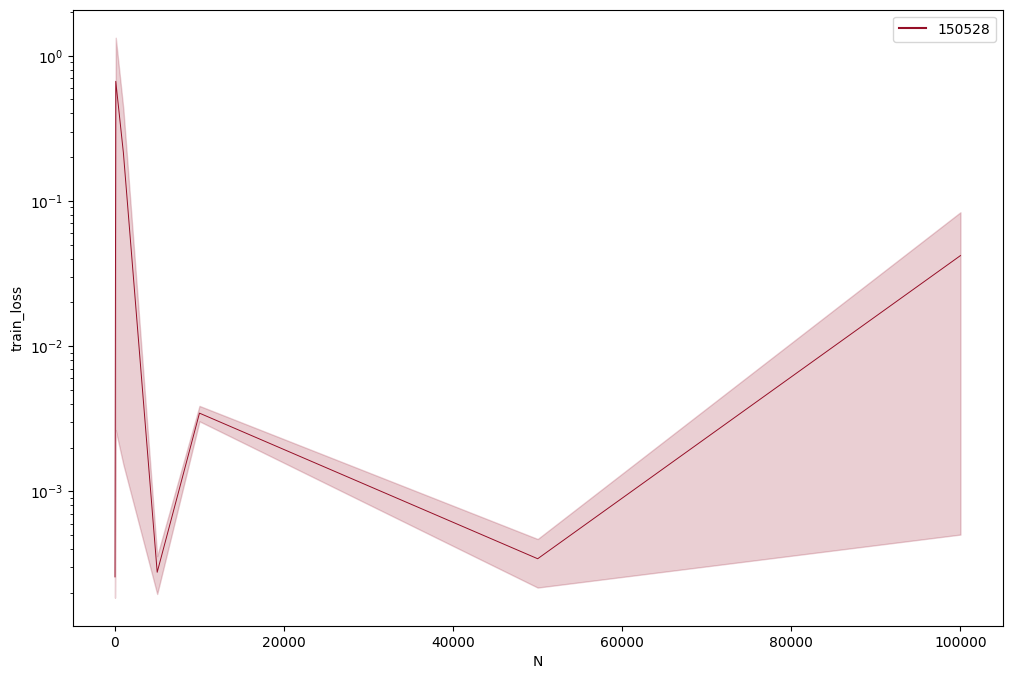

,block_size,lr,P,D,N,logP/D,logN/D,epoch,train_loss,test_loss,train_acc5,train_acc1,val_acc5,val_acc1
1,1,0.10,0,150528,10,-inf,-9.619319,99,0.000150,42.705785,tensor(100.),tensor(100.),tensor(56.7820),tensor(13.9940)
4,1,0.01,0,150528,10,-inf,-9.619319,99,0.000290,8.492419,tensor(100.),tensor(100.),tensor(58.1260),tensor(13.4000)
6,1,0.10,0,150528,10,-inf,-9.619319,99,0.000329,32.670654,tensor(100.),tensor(100.),tensor(56.9440),tensor(11.6320)
8,1,0.01,0,150528,10,-inf,-9.619319,99,0.000261,9.265911,tensor(100.),tensor(100.),tensor(57.8200),tensor(13.5580)
3,1,0.01,0,150528,100,-inf,-7.316734,99,0.002632,3.829030,tensor(100.),tensor(100.),tensor(57.5460),tensor(17.9200)
9,1,0.10,0,150528,100,-inf,-7.316734,99,1.327262,3.726766,tensor(93.),tensor(54.),tensor(54.4480),tensor(12.8860)
0,1,0.10,0,150528,1000,-inf,-5.014149,99,0.428273,3.951138,tensor(99.8000),tensor(87.7000),tensor(63.8060),tensor(19.5240)
14,1,0.01,0,150528,1000,-inf,-5.014149,99,0.001529,3.089814,tensor(100.0000),tensor(100.0000),tensor(72.8800),tensor(25.6700)
7,1,0.01,0,150528,5000,-inf,-3.404711,99,0.000358,3.380503,tensor(100.),tensor(100.),tensor(77.1220),tensor(28.8880)
11,1,0.10,0,150528,5000,-inf,-3.404711,99,0.000196,4.168438,tensor(100.),tensor(100.),tensor(78.4180),tensor(29.6140)


/home/qanguyen/anaconda3/envs/renormalization/lib/python3.7/site-packages/ipykernel_launcher.py:146: UserWarning: The palette list has more values (15) than needed (1), which may not be intended.


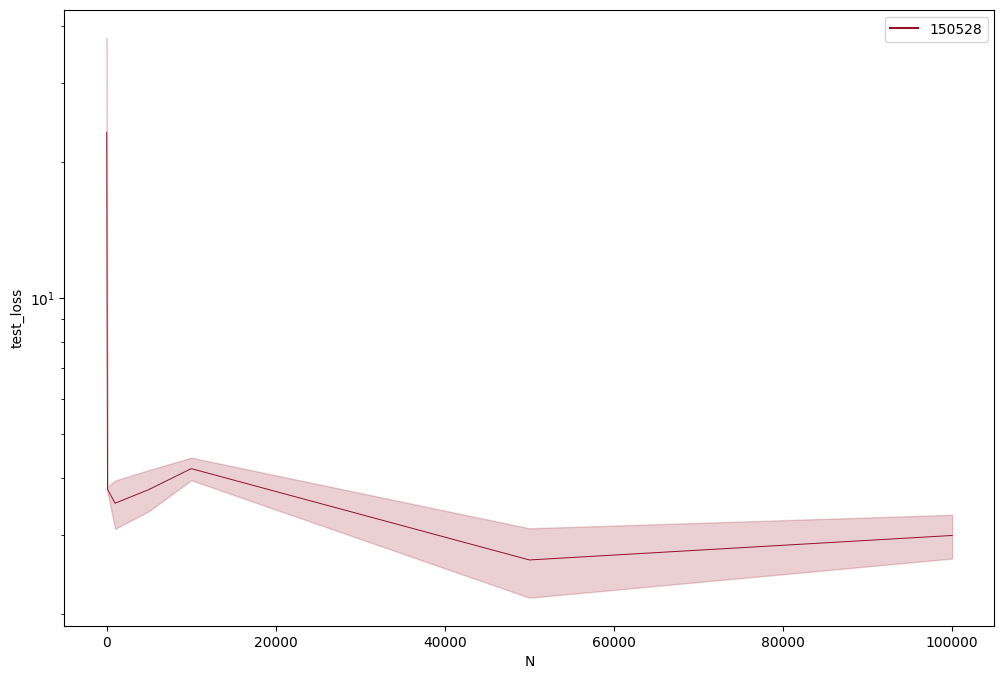

In [3]:

#for num_hidden_features in (5, 10, 100, 1000, 5000, 10000, 50000, 100000):
get_record(   
           is_online=False, title = f"Imagenet loss, loss vs. data_rescale",
           palette = sns.color_palette("RdBu", 15),
           outdir = f"{workdir}/imagenet_info",
           image_transform_loader_list = ['SubsampleImagenet'],
           hue_variable = "block_size",
           num_hidden_features_list = None,
    max_epoch =  99
) 
#     except:
#         pass